## Imports

In [1]:
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split

import os
from glob import glob

%matplotlib inline  

In [0]:
# folder to download dataset
os.mkdir("data")
# or 
# !mkdir data

## Download data & Pre-process

In [0]:
# get all classnames for the dataset.
import requests
resp = requests.get("https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt")
classes = [c for c in resp.text.split("\n") if len(c)>1]
len(classes)

100

In [0]:
# download the datasets -- 100 classes
import urllib.request
from fastprogress import progress_bar
baseurl =  'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
for c in progress_bar(classes):
  cls_url = c.replace('_', '%20') # encoding '_' in url with '%20'
  urllib.request.urlretrieve( baseurl+cls_url+".npy", 'data/'+c+'.npy')

In [0]:
# # visualize sample data
# drums = np.load("./data/drums.npy")
# drums.shape # 137299 samples of drums... each drums is an array of 784 cols.

In [0]:
# sample = drums[-100]
# print(sample.shape)
# sample = sample/255 #to normalize all pixels between 0 and 1 
# # int(math.sqrt(sample.shape[0])) of 784 since 28x28  pixels
# image_size = 28
# plt.imshow(
#     sample.reshape(image_size, image_size),
#     cmap="gray")

In [0]:
def get_train_test_split(root_folder, max_records_for_each_class = 5000, test_size = 0.2, random_state=0):
  #initialize variables 
  x = np.empty([0, 784]) # since each .npy shape ( ? ,784 )
  y = np.empty([0])
  class_names = []
  all_files = glob(os.path.join(root_folder, '*.npy'))
  for index, file in enumerate(all_files):
      data = np.load(file)
      # take top max_items_per_class records..
      data = data[0: max_records_for_each_class, :]

      # create [,,,,] for each class with idx as values .
      labels = np.full(data.shape[0], index)

      x = np.concatenate((x, data), axis=0)
      y = np.append(y, labels)

      class_names.append(file.split("/")[-1].split(".")[0]). #classnames from datasetfilenames

  x_train,x_test, y_train, y_test = train_test_split(x, y, test_size=test_size,random_state=random_state)
  return x_train,x_test, y_train, y_test, class_names

In [0]:
%%time
x_train, x_test, y_train, y_test, class_names = get_train_test_split("data",max_records_for_each_class=10000,test_size=0.3)


CPU times: user 52.3 s, sys: 14.7 s, total: 1min 7s
Wall time: 3min 21s


In [0]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((700000, 784), (300000, 784), (700000,), (300000,))

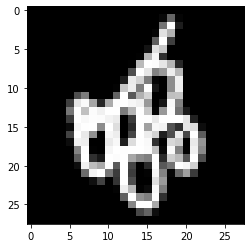

Class : grapes


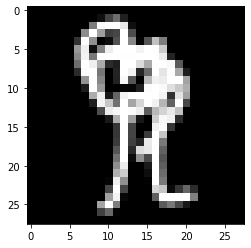

Class : tree


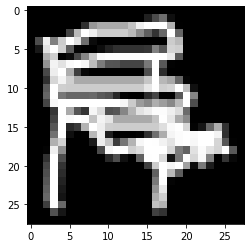

Class : bench


In [0]:
# visualize dataset
from random import randint
for i in range(3):
  index = randint(0, len(x_train))
  plt.imshow(
      x_train[index].reshape(28,28),  #reshape(28,28)
      cmap="gray") 
  plt.show()
  lable = y_train[index]
  print("Class :",class_names[int(lable)])

## Reshape and normalize

In [0]:
num_classes = len(class_names)
image_size = 28  # 28 pixels
print(num_classes)

100


In [0]:
# Reshape and normalize
x_train = x_train.reshape( x_train.shape[0], image_size, image_size,1).astype('float32')
x_test = x_test.reshape( x_test.shape[0], image_size, image_size,1).astype('float32')

x_train /= 255
x_test /= 255

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((700000, 28, 28, 1), (700000, 100), (300000, 28, 28, 1), (300000, 100))

In [0]:
x_train.shape[1:]

(28, 28, 1)

## Define , Compile - Model

In [0]:
def create_model(input_shape,class_num):
  # sequential.
  model = keras.Sequential()
  model.add(layers.Input(shape=input_shape, name='input'))
  model.add(layers.Convolution2D(
      128, 
      (5, 5), 
      padding='same',  
      input_shape=input_shape, 
      ))
  model.add(layers.MaxPooling2D(pool_size=(3, 3)))
  model.add(layers.Convolution2D(
      256, 
      (5, 5), 
      padding='same', 
      activation= 'relu'))
  model.add(layers.MaxPooling2D(pool_size=(3, 3)))
  model.add(layers.Flatten())
  model.add(layers.Dense(
      384, 
      activation='relu'))
  model.add(layers.Dense(
      192, 
      activation='relu'))
  model.add(layers.Dense(
      class_num, 
      activation='softmax', 
      name="output")) 
  return model

In [0]:
# create model
input_shape  = x_train.shape[1:]
model = create_model(input_shape,len(class_names))
# compile model
adam = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
                optimizer=adam,
                metrics=['top_k_categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 256)         819456    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 384)               885120    
_________________________________________________________________
dense_5 (Dense)              (None, 192)              

## Mode.fit() & save

In [0]:
%%time
model.fit(
    x = x_train, 
    y = y_train, 
    validation_split=0.1, 
    batch_size = 256, 
    verbose=2, 
    epochs=1)

Train on 630000 samples, validate on 70000 samples
630000/630000 - 39s - loss: 1.1490 - top_k_categorical_accuracy: 0.8935 - val_loss: 0.8436 - val_top_k_categorical_accuracy: 0.9357
CPU times: user 23 s, sys: 9.58 s, total: 32.5 s
Wall time: 47.3 s


In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 93.59%


In [0]:
model_name = 'quickdraw-e1.h5'
model.save(f"{model_name}.h5")

In [0]:
model.fit(
    x = x_train, 
    y = y_train, 
    validation_split=0.1, 
    batch_size = 256, 
    verbose=2, 
    epochs=5)

Train on 630000 samples, validate on 70000 samples
Epoch 1/5
630000/630000 - 32s - loss: 0.7578 - top_k_categorical_accuracy: 0.9420 - val_loss: 0.7677 - val_top_k_categorical_accuracy: 0.9407
Epoch 2/5
630000/630000 - 30s - loss: 0.6693 - top_k_categorical_accuracy: 0.9499 - val_loss: 0.7171 - val_top_k_categorical_accuracy: 0.9454
Epoch 3/5
630000/630000 - 30s - loss: 0.6100 - top_k_categorical_accuracy: 0.9553 - val_loss: 0.7206 - val_top_k_categorical_accuracy: 0.9463
Epoch 4/5
630000/630000 - 31s - loss: 0.5622 - top_k_categorical_accuracy: 0.9595 - val_loss: 0.7293 - val_top_k_categorical_accuracy: 0.9441
Epoch 5/5
630000/630000 - 31s - loss: 0.5221 - top_k_categorical_accuracy: 0.9631 - val_loss: 0.7434 - val_top_k_categorical_accuracy: 0.9443


In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print(score)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

[0.739238116856416, 0.94472]
Test accuarcy: 94.47%


In [0]:
model_name = 'quickdraw-e5.h5'
model.save(f"{model_name}.h5")

In [0]:
model.fit(
    x = x_train, 
    y = y_train, 
    validation_split=0.2, 
    batch_size = 256, 
    verbose=2, epochs=10)

Train on 560000 samples, validate on 140000 samples
Epoch 1/10
560000/560000 - 30s - loss: 0.4829 - top_k_categorical_accuracy: 0.9668 - val_loss: 0.6364 - val_top_k_categorical_accuracy: 0.9531
Epoch 2/10
560000/560000 - 29s - loss: 0.4444 - top_k_categorical_accuracy: 0.9705 - val_loss: 0.6617 - val_top_k_categorical_accuracy: 0.9512
Epoch 3/10
560000/560000 - 31s - loss: 0.4115 - top_k_categorical_accuracy: 0.9735 - val_loss: 0.7484 - val_top_k_categorical_accuracy: 0.9487
Epoch 4/10
560000/560000 - 29s - loss: 0.3811 - top_k_categorical_accuracy: 0.9764 - val_loss: 0.7587 - val_top_k_categorical_accuracy: 0.9481
Epoch 5/10
560000/560000 - 31s - loss: 0.3555 - top_k_categorical_accuracy: 0.9788 - val_loss: 0.7894 - val_top_k_categorical_accuracy: 0.9454
Epoch 6/10
560000/560000 - 29s - loss: 0.3314 - top_k_categorical_accuracy: 0.9812 - val_loss: 0.8569 - val_top_k_categorical_accuracy: 0.9454
Epoch 7/10
560000/560000 - 29s - loss: 0.3110 - top_k_categorical_accuracy: 0.9828 - val_l

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 93.14%


In [0]:
model_name = 'quickdraw-e10.h5'
model.save(f"{model_name}.h5")

In [0]:
model.fit(
    x = x_train, 
    y = y_train, 
    validation_split=0.1, 
    batch_size = 256, 
    verbose=2, 
    epochs=5)

Train on 630000 samples, validate on 70000 samples
Epoch 1/5
630000/630000 - 32s - loss: 0.3298 - top_k_categorical_accuracy: 0.9827 - val_loss: 1.0650 - val_top_k_categorical_accuracy: 0.9330
Epoch 2/5
630000/630000 - 30s - loss: 0.2919 - top_k_categorical_accuracy: 0.9850 - val_loss: 1.0752 - val_top_k_categorical_accuracy: 0.9324
Epoch 3/5
630000/630000 - 33s - loss: 0.2758 - top_k_categorical_accuracy: 0.9861 - val_loss: 1.1372 - val_top_k_categorical_accuracy: 0.9326
Epoch 4/5
630000/630000 - 31s - loss: 0.2631 - top_k_categorical_accuracy: 0.9873 - val_loss: 1.1205 - val_top_k_categorical_accuracy: 0.9301
Epoch 5/5
630000/630000 - 30s - loss: 0.2510 - top_k_categorical_accuracy: 0.9883 - val_loss: 1.2263 - val_top_k_categorical_accuracy: 0.9300


In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 93.04%


In [0]:
model_name = 'quickdraw-en5after15.h5'
model.save(f"{model_name}.h5")

## Predict some : on Test dataset

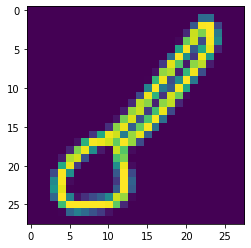

['spoon', 'shovel', 'screwdriver']


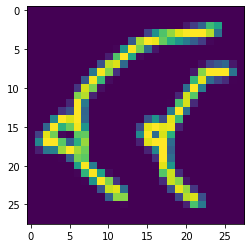

['bird', 'headphones', 'moon']


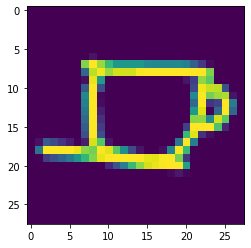

['coffee_cup', 'cup', 'diving_board']


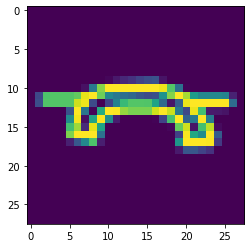

['bridge', 'rainbow', 'tent']


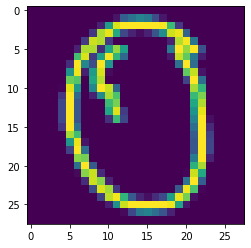

['smiley_face', 'moon', 'face']


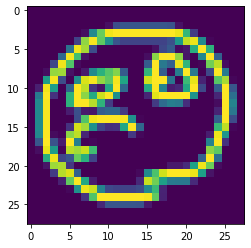

['cookie', 'moon', 'face']


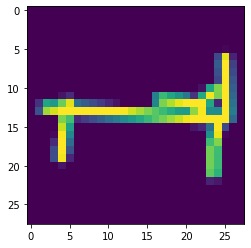

['bed', 'bench', 'table']


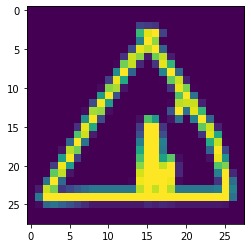

['tent', 'dumbbell', 'syringe']


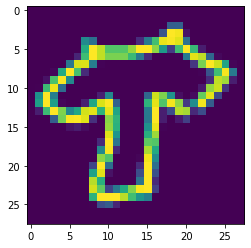

['t-shirt', 'hammer', 'tree']


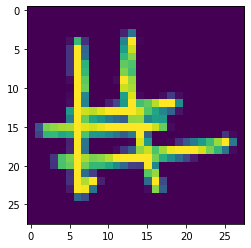

['ladder', 'sword', 'chair']


In [0]:
for i in range(10):
  idx = randint(0, len(x_test))
  img = x_test[idx]
  plt.imshow(img.squeeze()) 
  plt.show()

  pred = model.predict(np.expand_dims(img, axis=0))[0]
  ind = (-pred).argsort()[:3] # get top 3 results
  latex = [class_names[x] for x in ind]
  print(latex)

## Save & load Model


In [0]:
# Model name
model_name = 'quickdraw-acc94-ls66-v1'
model.save(f"{model_name}.h5")
model.load_weights(f"{model_name}.h5")

In [0]:
with open('class_names.txt', 'w') as f:
    for item in class_names:
        f.write("{}\n".format(item))

## Load from H5

In [0]:
def load_trained_model(weights_path,input_shape,class_num):
   model2 = create_model(input_shape,class_num)
   model2.load_weights(weights_path)
   return model2

In [0]:
model2 = load_trained_model("quickdraw-e1.h5",(28,28,1),len(class_names))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 256)         819456    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 384)               885120    
_________________________________________________________________
dense_7 (Dense)              (None, 192)              

['baseball_bat', 'pencil', 'knife']


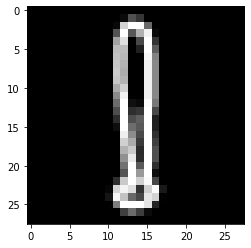

In [0]:
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze(),cmap="gray") 

pred = model2.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:3] # get top 3 results
latex = [class_names[x] for x in ind]
print(latex)

## Extras

In [0]:
import base64
from PIL import Image
from io import BytesIO
def getresult(img_base_64, model2):
  encoded_image = img_base_64.split(",")[-1]
  decoded_image = base64.b64decode(encoded_image)
  img = Image.open(BytesIO(decoded_image))
  plt.imshow(img)
  plt.show()
  img.thumbnail((28,28))
  # img.save("thumbnail.png")
  print(img.mode)
  # img = img.resize((28,28),Image.NEAREST)
  img = np.asarray(img.convert("L"), dtype='uint8')
  print(img.shape)
  plt.imshow(img, cmap="gray")
  plt.show()
  img = np.reshape(img, (28, 28, 1))
  img = img/255
  plt.imshow(img.squeeze(), cmap="gray")
  plt.show()
  pred = model2.predict(np.expand_dims(img, axis=0))[0]
  ind = (-pred).argsort()[:3] # get top 3 results
  latex = [class_names[x] for x in ind]
  return latex

In [0]:
# img_base_64="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAXYklEQVR4Xu2dzY5bxxFGL0caSskrJNtk7QCxvTEQ2HnueGBAG0sGrHWyTV4htqhoGPSMaHEokrequqp/jxEEQaZvdfepr7+u7kvSm4V/IAABCAQR2ATFJSwEIACBBYNBBBCAQBgBDCYMLYEhAAEMBg1AAAJhBDCYMLQEhgAEMBg0AAEIhBHAYMLQEhgCEMBg0AAEIBBGAIMJQ0tgCEAAg0EDEIBAGAEMJgwtgSEAAQwGDUAAAmEEMJgwtASGAAQwGDQAAQiEEcBgwtASGAIQwGDQAAQgEEYAgwlDS2AIQACDQQMQgEAYAQwmDC2BIQABDAYNQAACYQQwmDC0BIYABDAYNAABCIQRwGDC0BIYAhDAYNAABCAQRgCDCUNLYAhAAINBAxCAQBgBDCYMLYEhAAEMBg1AAAJhBDCYMLQEhgAEMBg0AAEIhBHAYMLQEhgCEMBg0AAEIBBGAIMJQ0tgCEAAg0EDEIBAGAEMJgwtgSEAAQwGDUAAAmEEMJgwtASGAAQwGDQAAQiEEcBgwtBeD/z1d7t9pa4fut3v0382+zd3t89qjoO+xyaAwRTOb21jKTzd37pLhvZgbMuyf3O3xdRqJaJwvxhMQeCzmsslxMl07u+X+59+2D4vmAa6KkgAgykEG3NZB82xbZ1Rby0wmAIZw1xskKlwbNxaegqDCc4G5uIDOJnN7v2ye/tq+9InIlFKEMBgAiljLjFw7/fLPRfFMWy9o2Iw3kQ/xsNcgsAehU1Vzeu77U18T/RgJYDBWMldee6rb3f3m80C2wC250J++LB84E1UIdjKblgESmCS5lQvEkq+bbij8eXpFQ2D8SL5MU5O9fLj99vQfHz57e7DZlk2I1dXHJucBZ0ZLlTQmWPr7nGruUQbSy2QB0NbNsumtNDe7ZZ3vHGqlflP/ZbOe/0ZB43Aeiw6NRerSQVNSxRWY5B//dvufzc3y02JKoq3TaL0hTbCYBzw9mgKDtP+LYTGYE77LXFs49jkmW1dLAxGx+tsa2v14tB1EyFyDOZ0ApEVjuc4mwDfwSAwmMwkzV69JHxRCzdVNzebxfVzLtzNZApe+TgGowR22nz26iXSYA6sv/hm9+v2dtl63dtwN5MpesXjGIwC1mlTqpdHIlEVzCnvB6PZLi88RMu9TIbwFY965ErR3VhNqV7KGsxBPeme5tmzxeVHq0qZ41jKl88Gg5GzetKS6uUTjlqL1CMHVDLGBSB8DIMRgjpu5iFsQ7fNPlLLYBIQj4vgmuNvNqlOA8NgFCAxlvOwai/QdDfzYru8UKTys6a8Xcqhd/lZDEbAtZaxUL4LknPUJDdPvF3S8Za0xmBWKJW4yOWnISVSlbfJOTZh6nLOkpYYzBVKkeaCqUjkaW+Tc2zCZOzcT5/EYC6wjDAXTMVPuNJIOXmsfbcknWPL7TCYM9nJEeVpOHbDuvLPuZchd/m5w2COGOaU1edSwQ6YL1CPCDkbBhe/eRnAYD7yy7kYvJQCDCZPnJ5P51QyvMK2Z2J6g+HnAezi6e3JHJNhs7Ble1qDyRGbBDWClFAq3yanUiWn+nxNaTA5Z3IpYsQoJVW+Xc5dG3nV5Ws6g/Eyl4PQLsVDiDoh1mht1QK5lWdrKoOxCuoU57HAMBi52FpsadUEJiPL5jQGYxXSNXNJf8NgZEJrtRXHpdjMDG8wOQI6Rn/pQ1elDEb7tosPickXDhe/clbalkMbjNebopoftsqdA0YjWxJWzvC9zndYg/E6EtX6kNWX3/7v3zeb+z/Ilsd6KxbCOiOrZmpuQOuzqttiSIOx7kaSI1GJdHmM/9w4+bLlevasJlNrI1qfUd0WwxlM7p3Lhw/Lh59+2D6vkZYoYzk3F96CXM6w1WRg+jnT4QzGKo6EpoZAtJe3XsZXY65eYy8Rx6ojuD7NzlAGYxVFDXMpWa1QwdgsyaIn7roGNRiLGA4oSu86OWO1LZXzT5Wet+fYS8Wy5Aqun7IzRAVjEUFCUGO3sY41akGxGNbJanNW8x5vfTZlW3RtMDkXuqVv/b/++/t/Lvv9n8qmV9YbJnOdk1ZnNTYuWabLt+rWYHI+fVnaXLzvW05fN2t32FOZsSDWF55Fbxj3snRpMDkLtvRiyl38p9K/39/8583d8z+e/v+5b6N2u80vP7+6/f36Upu3xVff7faaBVN6I2sxMxpe1cevLVVrvz3xNBeNMVr7Zce9LvFk4s+eLc+kC0GTM2nM3tp1ZTDWhVPjbVHuWA9j1og0t09NX70J3Wu8Wsazm/Y0BlMy0VoRnhO/ZrHnHBk/P4It92/utuJd2mvh9hJHy3r27yl1YzA5i7Ync9G84lw7MqZ5W7jtdptff351+7teFn3JcWqPSWlsJfVXkoWkry4MxrJIejwWaYQo2UnXftbzmkA0Y5EIbaQ2Wj3OfNnbvMFIFlLuEcND/NZxpr41x6HUXirwg0n85Zv3/91u96qKRDsmD4a9xNDmemaWzRuMdDEdi7PGudcyzocxbzb/+vEft3+WLi5NP8dViHZRpPHU4CjlULOd5Zg0axXTtMFYFkWNM69m0R8vDO0xxNKP5AfKry3WWRfGmoHl5mIt/ih/b9JgLMmrceeiOa6cCkZjLmuXuWtiPDoq/bLd7l+utc8ZqzZ2z+21n+6d8ag0lMFoFq2HsK1GqBmntYo7nt+xsLWLopZxe+SnRAytBjS5LzH+6D6GMZgaidOKS3t8s8Q/J5hTNhbTmnH3lSw+LcsaOpXMI6rNEAZTI2mWxS8dZ+6RSHLPYxk/9zHnl6GG5WwX590bTK2dVSOqJEvpOK1HmGPpS41AOwdtBRa1K7YWV7MhSHXQ2hyt4+neYKRVgRXQpee0i3NtnEmk29tlu9nkfcN9rZ/j+WgWxuG52RaIVDcaPWhyJO2/1XbNGUwvZ1ovQXlULDkXsZb+pRVSq6KPGJdGtxhMRAaEMTULt1bJrhHTpTFqY6zhyxGtZSw5/a3Npce/axjOxK65CqYHg9GM8ZyYNM+vLTavI4t2TF79rs2vp79LGc7EDoMxKFgqpHPVi+bZtaF5HlUs9zEz7cRruUh/l+Z2vyzL6++3za09yRy1bZqbpDRJNcUtHePxTmVZwJeSGbUDasr8NDbNT0tohdlje81PatbUb0m2TRmMdOHWuns5JEY6zoOILBepl0QQ/TkK6dzS+KKMruQC8OxLY9DRefScV04sDMZAT7oIk8FoRLc2FM8j0aW+tJXWLDvxWm60m0/tTVI6n9x2GIyBoNRgDKEvPlJyIWtMseS4PHlGxdJoo8SGETVPaVwMRkrqqJ1GRIbwTx6pcQzR/N5JjfHlMo18XmPOM7BrxmC0i7bmzqkdq0XQtc/o0jnO9EZEkkeOmE8pdWkwNc0l4ZMuPokgT9u0UjbzRsSSvcdnNPqorWX7LGVPYjAyTk9aaQSkCd+S2DSlfkvj1vCOaqt5azg6OwzGoDJvg2n1LC6d5+iLxCARcRUzOjsMxqAe6cKThK5913JtjNJ5jr5IJHk8bSNl13L+LfM+faY7g2lBzFLxrCWolfuWS+OUzrOFnKyxLv13KbtWq1cvXk0YjOa1aAtilornUpJ6EZV0ni3kxGtBeMWRskv9jcyvCYPp7UJRI55W3xJJFpJ0niMvEAmnc21607R1nmvPNWEwUiG34vaa8R4noLeFKJ1nb/NaWxQef8dgHil2ZTCtHC2kC69nc0ljl84TgzlvSfDrzGBa+HkAqWh6NxcMJr+OkWplZIPuqoKpnQipYEYwFwwGg8kn0FkFU9NgZjMXDCZ/eUk1U1PX+bO8HoEKRkBYKpTjUK3cFwmmd7GJdN4jLxD45RCgglmlJ11kp4FGWHTSuY8w11UhGBrAD4O5KhupQE6DjFC9cEQyOMrJI1L9jGzQHJEu6EgqjnOPjyIYKYNR5ptvKU8jwI8K5qymNB+SGvFodJgTC8RuORoNjWzQVDBnNCRdWCObC0cku7mkJzGYR34YzImONMI4fnTEXUhqtCPOPc9e5J+CTv2MzA+DMV7MjW4uGqMdeYFYjUZqzqO8ELjECYM5IqNZVIfHRl1c0gUy+g4cbTD84JSVsOI5qZijF7N0HKObi9Zoo/OikFIzTaVaGp0dFcyRJKWiGH3X1nAYvcS3OpaUIQZjJax4roVkaHbtkReV5tcFRzdahYQ/a9qCpnPG7/UsFcxHklJBjL6oMFqfpSXVExWMD++rUWonQ7OoRjcYaS5G55AreylHDCaXtOD52smQ9p+mMvLxSGO0I3MQSHa1iVRTGMwqyvwGNZPBncOn/EnzkJ5o4dcF85UXF0HKEoOJy8FvkWsmg137MQ0aDhyP1hdFTU2vj65ci+kveaVCGH1RaThwPFpfoFKeVDDrLLNb1EqG5ng08qLS/MvaRzfabDF/DFBL017j94ozdQWjORaMfOcgXQyjX3J7LSqNYVPBeFG/EkcqcO9kSPsdedf+4pvdry+2ywtpmr1zIO23p3aajWt0nlNXMFKDGfl4pFkMI3PwNLCvvtvtpQsLg/EkfyGWdKF7J0PaL8ejx8S92y3v3r7aviwgia67kOpqvyzL6++3Ui/qkkkTk5MmxNNgNDu3Z78tqURzyT3yMdE7J1I9z1ARYjACdY1qMNKFkBCN/rslAhmIm0i5zsB0WoORimDUnVsz/1EZiB1D0ZDK+CksDGZFPCOWsZpFwKtphbukT0RzwfsEGAazop/Ryljta+mEZ+RLbp19rLeWVoYzXPAmWlMajGaRjXb/Il0Ax0tpNAbrNmFvIeU7YmV8jtqUBqM5Ioy0uDTzPohlloVgt5SnT0oNZiRdXWOHwawoayQhSMVP9WK3GynjkXSFwZwQmPEizlK9zLII7Hby9Em+g/Q5ya4qGK8LV6nBjHIRpxH+QSKYi952NCY+C9+uDMbrPkBaxnr1p5eq3xOaC+1Dr3wlwMZfunGl6BiMjbHpqdILvnR/JihOD0nnyqVuPnAp61EqYwmxvioYpy+HiYWwX/av77Y3EpAttpHOk0tdn+xJeY9QGUuJNWEw0tLSy/mlQui5jNXcB1C9SJfL9XZSXXndJfqMOjZKVwbjdXaVCqFng5HOkerFZ4Fpvpnes660tNowmG9395uN7FPFHsmRLj6PvrQJ8WgvnR/m4kH7MYamYuxVVxZaGMwVaj0KwWIuvDWyLJ2nz2Aw5xliMAMZjMVcZroPyLeRyxFK3yNGzsUzdhMGkyYkXRweVUXJvjyTdS2WdE7HMWZ6mxGdByn/2Zh3ZzAeO65UDB5mFi1sjTmfjqWX+ZVgmNuHVFMYTC5p4/MlEyTtq4cFKJ3LaVpmE7pRluLHpHmY7bd1uqtgPD4LIxVD6wYjnce5VdL63MQru4GGvKK+nIRmDEZ6SZamkrs4NAszt68o/WvmwNEoKguPcXmD1IPBFPwsjGZxtmYwli8vHqe/tfnELv0y0XvWUzShZioYzU8K5C6SXgWh2Sk5FkUvncf4muPRjPdezRiM5m3IbAaTaywex8oyy7W/XjS5me2CN2UTgxFoOtfQBF2cbaIR77U+ao3fOu+enuu1Gi7FGIMRki65SL2MhcpFmFxjM02eZjweUcEYhBVpNBrBSoYeOVZJ/6O30VQvMx6PMBjjCrjfb+7f3N0+0zye3v7c3m5uH6HvHypH6TfINf0c2mIuFmryZzQvJWauJLs8IuWWm5qdRy65dlpiLvG50GgoV6/xs4nroU+DyfzpTI044tD7R55ZyP40L0fUfhZpZsPv0mA8S85RzIbfdClnMZq7stlNvymD0STOc1fo2WRmF3A5W/nUk0Yvsxt/UwajKT29F5ZGNDVEfdqn9/xbmFMvY9BoxXMj7IXP8TibMpg0MGnyPL5VfZowad81E42x1KSv+2Kjx28X1Z1tfu/dGoznPcwxxlZNBmPJF7tHhJLf+vcYb+0YzRlMrXuYVk0GY6m9RJ72L92AIirstkjIRtOcwWjuYaLPtxqzk+GWt8JY5KxKtdTogfw9ZqU5g9Hcw0QbzLFwk7iWTfrwrc8/aYd7+Ge/PPzP3ftl9/bV9qVPdKJEEJBWL1HH94g5Rcf0Wi+u45QmsqTBuE6QYN0R4KsBtpR1bTCUobak85SegHTTeyhK98v+9d32Rt/LeE90bTCUouMJssUZae4F0eTTDHZvMOwWLS7JscbE5a49n00ajCah7Bj25POkjIDmeDT7VwNOiTZpMGmQmqTO+mM+suVBqxwCbHY59Bp9TZ2mRGLzEsvTPgQ0Gx1fDficebMVjLaK4ajks6CI8okAm1y+Gpo2GG2CMZl8QRDhkYD2zREvG84rp2mD0fxLrQ7T48N3WIQHAc3RiI3tMvGmDcZyTOIW32N5zR1DWzlTvXRsMNpks5vMbQ4es6d68aD4GKP5CsZSxbCj+AlktkjaDQ2tXVdIFwZjMRnuYmazBp/5Ur34cDxE6cZg2Fl8E0+0zwloNcZ937qKujEYqpj1ZNLCTkBbuXA0krHuymC0n03gwlcmgtlbac0FXckV05XBpGlpy9j0DKWsXBCztbSYC9WLXCXdGYzlqJSeQRRyUczS0rJZUb3o1NGlwViFQTWjE8fIrS3H7QMP3lDKldGlwVirmAMWvvUqF8iILXM2KCoYnSK6NZhckXBk0glllNaWO5fjuaMbnRK6NZjcKoZyVyeU3ltbvjiLseRnvWuDwWTyBTByhHTPsr1dtptN3ldiuHOxq6R7g8Fk7Mkf9Untv8PoGgfMJU8lQxhMQpB7J8Mbpjwh1X7aI/+nc+C+JT+rwxhMQpHz6pE3TPliqhEhwli4n/PL5FAGc8CSKzp2Lj+BeUZKR5/Nx58Yyb1XuTYu8u+XtSENJuHJPYcjMj+RWSPlbhSWfvlaiYXa5WeGNRivIxNG4yu4a9G83vpYR0yureQmNZjDtHM/XJXiID5/8R0i5labXiPjjZEXyU9xhq5gjnF5mAxGkyfA9GG3zc1ms1n2D7qLvEfRjpQNREtM1n4ag0k4PM/0CHJdYIdL2ZaM5LBJ3N8v9z/9sH2+Pgta5BCYymC8TYaK5nPpeZp4jrDPPcuXXL2JrsebzmASkqgzf6pq9stm/+bu9tk6+jFa1L6YXaOYcrJ7v+zevtq+XGvL3/0JTGkwCaPHh/LW0jGauEt9DmWN69rfOb6uESr392kN5oDY6/J3LWU9lee9GMkpc4xlTYXl/z69wUTcy1xLY0tVTa9G8nD39fhf+/2y7N/cbac5kpa3iLweMZgjfqUvKEtUNS2/GpZK92Amr++2N9JnaNcGAQzmTB5KG00bUmhvFCUMuL1ZjzUiDOZKPjGa8mJv6QhZfvbj9YjBCHKK0QggKZscjj3pMT70poTXUXMMRpEsjEYB66QplYmdXc9PYjCG7GE0Mmi8NpZxGrkVBpOZ3Va/b5M5LdPjj59k5rWxCd6gD2EwzomN+hqC8zCzw/E5lGyEUwTAYILS3Pp3dKTTxkikpGh3jgAGU0AXPVQ1GEkBIUzYBQZTMOm1qxpeDRdMNl09EMBgEAIEIBBGAIMJQ0tgCEAAg0EDEIBAGAEMJgwtgSEAAQwGDUAAAmEEMJgwtASGAAQwGDQAAQiEEcBgwtASGAIQwGDQAAQgEEYAgwlDS2AIQACDQQMQgEAYAQwmDC2BIQABDAYNQAACYQQwmDC0BIYABDAYNAABCIQRwGDC0BIYAhDAYNAABCAQRgCDCUNLYAhAAINBAxCAQBgBDCYMLYEhAAEMBg1AAAJhBDCYMLQEhgAEMBg0AAEIhBHAYMLQEhgCEMBg0AAEIBBGAIMJQ0tgCEAAg0EDEIBAGAEMJgwtgSEAAQwGDUAAAmEEMJgwtASGAAQwGDQAAQiEEcBgwtASGAIQwGDQAAQgEEYAgwlDS2AIQACDQQMQgEAYAQwmDC2BIQABDAYNQAACYQQwmDC0BIYABDAYNAABCIQRwGDC0BIYAhDAYNAABCAQRgCDCUNLYAhAAINBAxCAQBgBDCYMLYEhAAEMBg1AAAJhBDCYMLQEhgAE/g/MV3LNK3YBYgAAAABJRU5ErkJggg=="
img_1 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAZcElEQVR4Xu2dUbLsNm6GJU8q9kOqJpXN5CmLyBpmA6nZyCwhW8gi8pTNZFLJgz1jWykdd5/p26fV/EECJER9t8oPrkOB4A/gE0ipu9eFfyiAAigQpMAaZBezKIACKLAAGJIABVAgTAEAEyYthlEABQAMOYACKBCmAIAJkxbDKIACAIYcQAEUCFMAwIRJi2EUQAEAQw6gAAqEKQBgwqTFMAqgAIAhB1AABcIUADBh0mIYBVAAwJADKIACYQoAmDBpMYwCKABgyAEUQIEwBQBMmLQYRgEUADDkAAqgQJgCACZMWgyjAAoAGHIABVAgTAEAEyYthlEABQAMOYACKBCmAIAJkxbDKIACAIYcQAEUCFMAwIRJi2EUQAEAQw6gAAqEKQBgwqTFMAqgAIAhB1AABcIUADBh0mIYBVAAwFwsB7Zt20pLXteVvCiJxN8lBUgkSaZ5BgGYeWJ5hpUAmDNEydFHAOMoJqaKCgCYokRzDQAwc8Uz+2oATPYIOfsHYJwFxdxbBQDMxRIEwFws4IOXC2AGB6D39ACmt+LXng/AXCz+AOZiAR+8XAAzOAC9pwcwvRW/9nwA5mLxBzAXC/jg5QKYwQHoPT2A6a34tecDMBeK/7ZtvyzL8l1pyXxUoKQQf1cVADCqUhOMU7qXfZkAZoJgJ1kCgEkSiB5uAJgeKjPHowIA5iL5oG6PbnL8tK7rDxeRhmUGKgBgAsXNZFrtXm4+b+u6Fs9qMq0PX3IqAGByxsXdKyNgOIdxj8A1DQKYi8TdCphlWX5d1/V3F5GHZQYpAGCChM1mtgIwdDHZgnhCfwDMCYNW43INYJZl4bC3Rmyu+VQAwFwgGYxPkB4V4bD3AvkRuUQAE6luEtuV3cuH97x0lySIJ3UDwJw0cKrb27b9uCzL9+r4F+PoYhrEu/qlAGbyDNi27de9EWlZJl1Mi3rXvrYp8a4t3TlW37I9elghXcw5wp3OSwCTLiR+DjUc7n5xgi7GLy5XsgRgJo622L38JJ7R0MVMnCtRSwMwUcomsKsAZu9M1HMaupgEQT2ZCwDmZAGzuCsA5rMrEcbuU/PxAUsAGNv2dAH98iogPp7+fFOXLiZvLM/s2WU6mP3A80of3lOA8bzlUboYtklnLvf+vl8JMNsu71UKpAYWCpTYJvUv0jPPeDnAXAUyNYDZtam97sxFgO9xClwSMLNDRnz/5eWBLYCJK7YrWr4sYGaGTAskWuB0xQJize8VuDRgZoVMC2DYJoEMTwUuD5jZIOPRgbQCyjNBsXVuBQDMU/zO/pTJAw7K06Sz63Tusj2P9wDma6z292X+7jwh/NZTD8CI2yQ+m3TWJOnoN4B5L/b+7sz+tOUUwPHYHt3l8AJVx1xmqoQKABhbUD5e1ttfF8n4VrAnFDxt2SRm9EwKABifaO7gGQ4dTyhwDuOTGFe3AmDiMqD79koAjOncxNtenNRYzqoAgOkbmfsW62Obdet63M53BCCYDrAFe5f5bFffNJlnNgCTK5bVXc+2bT8vy/L2p16tj5YVwPDjbLkSKJs3lwGM5elIoiDJwIk4MxGfStHFJEqYbK5cETDNP+MxMIiHwFG6DWsH87GP27bHbd3LpdfYHaghU3dU4HKAUYumYww8ptohUIxlDQiUzuh2lvSdx0KwMZcCxaSca7l/W41yZ95HP3wp9sf/nlyPqsfpilY18Dq5lrgvKHD2ghGWeDxEKZyju/PtO2//fhLofDR2Ry8PijrxheBN2TjnxVcHjHoeIxXP7VB013QGXT/fWl6W5a/KbyfRxcwJiZZVzVAILeuXDjFvE3x+A79lwtvj4/v5xNR6AxhLZlxj7NQJr4RQPMT8MBVRQA8AmiEWVWc8SpwYc04FZkjqZuXFM4b7OUXo05LJgPOh2e2/v67r+kNzsDBwKgUAzG/vevyonDHcIiudx3hlwYTAATpeyXECOwDmFiT1rdWW8xivfHh4gvWxc/OyO9gO26vBAYiYfpbkdNFm9HlMzSKE7d39adAZY737/he2VjWZkeOaMyZdqHJCwd7n77pVerVoBYhHB9O3a8/WAZm+biI0UTAuKQBgnmSynMdEPFWSova3bZ3754ROBB75g6AWTRnrqwCAeaGneh4zI2CO0usk4En9laa+pXsOawDmIE7K9mP0h/yE7VzIlkKYN1P2c44zMBoA5o34YiGZviXOK9biVq7q7eOSj6Iu0ie8S3M5/334uZnzetKbAzDtgAl5w7eUOUqHFbWFq9lCJvtwaEhnV4rZFf8OYN4D5pdlWaQ3d6OK+c2ZiPsBr6UAlC6mpEkC6HBQbAl6xVgAUxBNKaT7Q511XSUYVcTpyyWKX6UCb/FD6aBqzqgGfiKdrqYlIQ6uBTBlwFg+RhBy5vHKRQEw4QUj+NC8fRz0UQk+P+UEGwAjCKmeOeymIruGR1eF4k4BmNtP7779tQMhBJ9DxM7JYlIZy1ZKUenFGAAjCmdI7PDC3l0WABP+dEt8khUK3QHv53SJr5iW6YcBGEOIhKK+Wwt/HFryJVEnFQqYN4fg6rcVGjLg61HYrUNz+/G8FmcyXgtgDFFR79g3k2HnMRE/smaQ4ZuhSmfXC3YHZ1Xyk8BaDW7X8UIfW6TGFPptayLfGaMKS/Ehau5nBTPB7l10jTeH1kQJ72BbHex1PR1MhdKl7cmDyZD9eibAZDkPsoRR0c9irzD20rABMJWZZICM+1ZJmbtXByMCJgS0laH7vEzpvlrneLzZXPG7bQBMZQZZktOz2NW7r+ecJYmyAa/k78FZzf6+U8/fubrEmQ2AqcnG+6mefh7jdgdXirnmDdoGGZRH5kOeJLWs6daZyedtrXP1vCG0+mq5HsBY1HoxViz4/UqXrZIyX+9kFV9EPO1ZhKVbrU2n3jGr9dN6HYCxKvY03vJ0wiOJBMC4dUsWaQS/TtnFPGsQ9dEFj9ywxKvXWADjoLR6LuLx2rxQyADGIaaKCcvNpWQPwJQUuvjfhcL/UKg1kYR5XLZi1nDOvk0q6SGu/9BMa16U/Bv1dzoYJ+UNd7PqDkOZY2SiCvBrBqxTuNzNGLrYl3OPjJu7GA8GAYyjuoYkq+oyFPsjE/WKgGntXO7pNzJujiXwxRSAcVZXKbLardIJAKN87ue0T5MeU0XpJi2pBWAsal14rOGOZt4qKfAanahn8LE1PRXQq3OMjpfqZ+04Opha5d5cpxRZTRej2B2dsGfwsTbkhpvHuymqtse1Po++DsAERMDQPpu6GKF4TfYClr6/1TvdNsnpy8mn2BpacwbAWBUTxxva6D+u6/qnklmlcEd3L/c1CCA8zdMkQxwPQ5glLqUci/g7gIlQ9WZTKTT1c0NKomdJZGXdWXw9Cr+hC2U79EYBABMLGGW7sHtQ3JefqWjPBMNX4Vf8L6TNJbdDrzQBMIGA2U0rYFAOfAU7w89fHrZIPy/L8vaXBDJ2MA4fakwTg+C0ls0DGFmquoGGpD3sYsR2PfxXBCwKCEDM5m/TVzNkBKYlXlFjAUyUsg92hWL7GH2UpErLni3BhTWnuNsbbgBHmZIKlB3S2TQFgDHJVTdY7EB24y/37kKxpnsqcwafFXC/iXgKQNZlZL+rAEwnrdVkftWJnKFYn2XM7LPyyL+QFsVD+U5plX4aANMpRNu2/duyLMX3XZ4fW4vFkO6pRUa/DZ3kUVbQtRjrBcAYBWsZrnYxj4+tM3cCJS0y+W7Q/mhZdC2lgL/4O4CpEK3lEqXoHg98lfHZDnjv+mTwna6lJVvbrwUw7RqaLBjupPvPWuz/fVeYIN326AEwyouGYf4btKZrMWWxPhjA6Fq5jVTu7OpkWbuXkV2Mw6PnMOipcZ1lHIAZEEmHtv3TawDzbQBbu5bseg5I16YpAUyTfPUXtxbCbeb0d1plnR5F7dC18MJcfTofXglgAkRVTbZulTwKU/W1dpxS+K3rUCD2xn8ePdcGV7gOwAgiRQ1Riu/d3K2FGbWuZ7sCSKu6B4etJo+eg5MAwAQLXDIvFN+RidPceYU1mtcivsh3eu1K+ZP97wAmQYSEAnzl5Wnuvsr6LN1Y45boNLolSM1mFwBMs4TtBmruxpaCbPewzYInYBRbB96au6S2VXP1rgCASZIH1sI5GWCK37VSWk/jeQtdy6A8BzCDhH9xEPrjsizfq+6UClK102OcsqV5t56aDu+2rvSP8XvoP3IOADNS/ae5lUJ8uORUd+VSh9byZVuvQngmACdKQXdXAIy7pG0GS4X4ZP2f1nX977YZ+1wtrOvLGYlwzSvnOWvpE1JpFgAjydRvkLGLSfdNdkdKCbD4BEPDeQtbon6pKs0EYCSZ+g0SCvHL8c26rqVPXPdbwMFMyrr2bY0VsGfdMg4PSCcHAEwnodVplEJ8YSv9tkBc1/71FOac5LxFza7+48zB7O/itWYUC/F0Zw8NT4LeJUB6sF4re7+uFsAkygCHIkz9ZKkBnq+ixHlLotw9cgXAJApSw/nD4yr+c13Xf0m0rE9XnNa320sN0ozaj/IJwIxS/tVByrbtZxDN/7KeSWzb9udlWX7fssCsa2tZ08zXAphE0XXcQqQ9m2hYY9o1JUqhdK4AmCQhEd/9sDxlSbeNaNgipVtLkrRJ7waASRIipfis74lk2U6I8HwZiSxrSJImp3MDwCQJmbJ1uBebAqPbsoZvKwy+PkdiuO9JUuPUbgCYJOGzAGZ3WRl/W9qw7UUDXE7zEYgk6ZPWDQCTJDQCML65o1u2Hb23GRbfjuTv7XOSNJjODQCTIKTil39/6UQMHUK37Ya4lqLqAKYo0SkGAJgEYVJA8eb7UtR3Z8K3Sg5vIn9GA8AkSEwHFwCMg4itJoTt0eGZhGU7Elm0CiQtOkX6avGDsW0KAJg2/VyuFgDzdotjKO6QrZLgf41OIb7WOMI19QoAmHrt3K4UCrT4wT7Bxt3foi3LwgzzPpr9Sfn+YboYSyRyjgUwg+OinFsohTZiq1QDl4d3eYpnR8q6B4eP6QsKAJjBKaJsb9RCU2zdl6vaPJKnAi7Pj9l/WZal9E18rt3W4FBfcnoAMzjsSqFaYKDYuy25+ozDMMfbbZlix7L2waFk+hcKAJjBaSEUmQkElq3Ssiz/ta7rP1skEPx9Nnf4w/aKLQBjiU6+sQBmYExEGBwW6Jvti7L9+LhcLWDR12eX3r57o5w/LcvCNmlgjrZODWBaFWy4XjkzUQHw7IbSHahbJREE37ig+q34qdpqCAWXBikAYIKEVcxGF5di/+bnYaehQPB5rRYgKD5a7Cm6M6afAgCmn9ZfZoouLsvngp6LuHJLJG+57mKI3ZHpHGpgSJn6SQEAMzAlBMA0F5alA3l4R+XnZVl+Z5WmttMQdDCDy+o742MUADAxuhatKnfu2oJtOY+5XWvOixZfFcDsX4Fzhl+wLAb+YgPMiXQxfcKWq3QWLUX76HjtdkddfKufCmx3X1rnUdfDOD8FAIyfliZLyl3bs6AUoJkW8Ntgt66itx4Va+WSCgUATIVoHpcIBeVWvHd/hTktSzO/n/POuOKbJ3AtC2VsvQIApl676ivFpzuuBfzRbmzbj8qnmIWFuX95FYARVD/hEAAzIGjKdiXqbq2edxzI4t5VGbursPkHpMElpgQwA8I8+m6tAO6FLKGv7Ks+RYF3QBpcYkoAMyDMAmBC79QVWyX3LdEr2QVd9stCQTcgHaaeEsAMCK9QSKFFJMz/rEoo8B62Sb/uT6NLIaGLKSmU5+/FYOZxdQ5PlK1AVAFVdC6PoveCDN90N0eqf6wCwHQOptI9RACm8XD3rlL4VkkBMNukzknbMB2AaRCv5tIRgBGLVlpOBPy+7Me2jS5Gikb+QQCmc4wEwLhuRYT5rAq4+ld72NsDdFZhGP9VAQDTOSuEgncrYGGu2tW7+XgAGOUb+UIPwmuF4bpvFQAwnTNCKHqXN3iFeV6tfH+KU/qm/98O79Y1NHcU/6N96JwaU04XmiRTKta4qFLheBRNzZnLw3fBSI+KoyFT0il6/sYwc/lNAQDTMRWUJzmtgKmAy5ftjlLcN9nCtkqKD61adQz9ZacCMB1DrxR/S9EoAHta7stzDOP7MiGPrgFMx8QMnArABIr7bDoSMEYo7K55/KRI2HkMgOmYmIFTAZhAcV8AJuz9DqUg7/6oXZLBpvtWSZzbfd6O6XCJqQBMxzArRaMW/6Pbil0rXPbx27bt+bEf+ir/XJ5+3SdSuj0OepWwjB0DYDrqL4DAfEdWC/G2TPN5ifjlWCFbJUGv8MflHdNjyqkATKewKiCwdi/Gc5fqF9MU32s6pJL0AKakUP6/A5hOMYooFsXmbXnmzqjm/Oh2TTXIaua0QrlTuJnmpgCA6ZQKCgwsxaLY84LL7TzG8n2+5q3YqzCIa2yGZ6cUuOQ0AKZT2IVikQtFsPW5Kgu0SlJY3rPxmFfdmnnMVVo7f69TAMDU6Wa6SikUtUgsRV5618W0iHs7JHyVgud5jAJTVbua9XJNmwIApk0/6WrPIlFseW6NGrYuHzur1p97VdYLYKQ0HDIIwHSQ3atILE+NIovO8ui6FTJe2nUIM1O8UADAdEgLoUikO72y1dqXEwmXu1yqL63dlKBdl/V2SJMppwAwwWFVClEFQrZiU/x5kLfq8bU4hwTo4FBjng6mfw4oBaIARgFV63bEqs62bb9fluXPhuvMHydQ9OvVtRnWydCbAnQwwamgFIgImOIHJSOeGpXksZwL3WyZ3pERwco2qRSoQX8HMMHCC4AptveCjY9VKKCKWG4HyBThOmrtEXrOZBPABEZTufuWCsPwxKbqjMNr+QY/zTBUAFvS0Wud2LEpAGBseplGexSGYmNk9/IoiPElQLnjUjQAMKbU7DYYwARK3VoYSgd0c998eBq1bIPPcifTqmPUWrFbVgDAlDWqHiEUxtvzF+F6uUirF1FxoREyLmdQdDAVgepwCYAJElkpsndFcVa43OVU/b+NbwYtgAlK5EazAKZRwKPLlQI7KgrDgWnx7h+0PMmsosGDocNDatFOai0kwSYcBGCCgqoUxRvAFB/LZjnYLcmn6FCCjGqDLqYUjf5/BzBBmgtF8fKOa3gSk+Zg952E27b9w7Is/2uQ+cuLeMp28yzANegwxVAAExBGpSCu0L08nMdYvg1vv+w/1nX918fQCMCWH3sHhByTBwoAmIDUqC0G9Y3YM24F1LXdw/G8xlpNA8KLSYMCAMYgljq0thiU63p/oFFdszLOsP3bzX2zhVS0OSN4Fd3OPAbABERPKIaj85fi4e7Zi0jZPr469BU0ZYsUkMutJgFMq4JP1ysF9AoSynVn7l6ezlP2X4uUcu+u1bZt+9dC7F8PcfTvf9Z1/UfncGKuUQEpyI1zXOry2jtt7XVnFVdZ79F5zFnXfEW/AYxz1JXCeXGA+cuyLN+VXDn79uh5fYpWt2uGflK8FBf+fqwAgHHODqFovpy/CNfsXpq+qMl5WSHmjE+Wplt/iKjJjAIY54AIsKgCzGzdy112y5OlWTVwTsFU5gCMcziCADP152wEzT6jBGScEzbYHIBxFlgolm/OE5SnR1coKkE3IOOcqz3MARhnlUuFwhuqrwU3fIL8w8AVoOucmkPMARhn2S2AUbqXKxWTqsctZFNvG53Tcpg5AOMovXJg+XjnLcHo5tqlHtGKmtDFOOZtpCkA46iucgd+eDNVepv1ilsBFTJX1MYxXbuYAjCOMhsBU/zc0SwfDaiRWITMKb4Tp2b9s1wDYBwjqQJGGXels5ejELyBzA7nH9Z1/Ytj+DAVoACAcRRVvOv+tCzL98K0lz/EfNJzh8q/r+v6B0E7hiRRAMA4BkIEjDQj5wvLcjs0/791Xd99ilrSk0FjFAAwjro7Auby3YtjWDA1UAEA4yi+F2DoXhyDgqmhCgAYR/mdAMOnhh1jgqmxCgAYR/0dAMPWyDEemBqvAIBxjEErYNgaOQYDUykUADCOYQAwjmJiagoFAIxjGAGMo5iYmkIBAOMYxkbAXOpDjY6yYyqxAgDGMTgtgOH8xTEQmEqjAIBxDEUDYHh65BgHTOVRAMA4xqIWMHQvjkHAVCoFAIxjOCoBQ/fiGANM5VIAwDjGowYwdC+OAcBUOgUAjGNIAIyjmJiaQgEA4xjGCsDwaNpRf0zlUwDAOMbEChi2R47iYyqlAgDGMSxGwHC466g9pnIqAGAc42IBDN2Lo/CYSqsAgHEMjQEwdC+OumMqrwIAxjE2KmDoXhxFx1RqBQCMY3gAjKOYmJpCAQDjGEYA4ygmpqZQAMA4hhHAOIqJqSkUADBThJFFoEBOBQBMzrjgFQpMoQCAmSKMLAIFcioAYHLGBa9QYAoFAMwUYWQRKJBTAQCTMy54hQJTKABgpggji0CBnAoAmJxxwSsUmEIBADNFGFkECuRUAMDkjAteocAUCgCYKcLIIlAgpwIAJmdc8AoFplAAwEwRRhaBAjkVADA544JXKDCFAgBmijCyCBTIqQCAyRkXvEKBKRQAMFOEkUWgQE4FAEzOuOAVCkyhAICZIowsAgVyKgBgcsYFr1BgCgUAzBRhZBEokFMBAJMzLniFAlMoAGCmCCOLQIGcCgCYnHHBKxSYQgEAM0UYWQQK5FQAwOSMC16hwBQKAJgpwsgiUCCnAgAmZ1zwCgWmUADATBFGFoECORUAMDnjglcoMIUCAGaKMLIIFMipAIDJGRe8QoEpFPh/m3/kr63sWOQAAAAASUVORK5CYII="
img_2 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAVyklEQVR4Xu2dO64tORVA7f7QjdSCDgmRXkYCY2AIECIyBsCESBAhEswAZgAZSauJCaEloL9Gdfvcx7l1XVX29t72ts+64Xvl39qudfyrqhj4gwAEIGBEIBrlS7YQgAAEAoKhE0AAAmYEEIwZWjKGAAQQDH0AAhAwI4BgzNCSMQQggGDoAxCAgBkBBGOGlowhAAEEQx+AAATMCCAYM7RkDAEIIBj6AAQgYEYAwZihJWMIQADB0AcgAAEzAgjGDC0ZQwACCIY+AAEImBFAMGZoyRgCEEAw9AEIQMCMAIIxQ0vGEIAAgqEPQAACZgQQjBlaMoYABBAMfQACEDAjgGDM0JIxBCCAYOgDEICAGQEEY4aWjCEAAQRDH4AABMwIIBgztGQMAQggGPoABCBgRgDBmKElYwhAAMHQByAAATMCCMYMLRlDAAIIhj4AAQiYEUAwZmjJGAIQQDD0AQhAwIwAgjFDS8YQgACCoQ9AAAJmBBCMGVoyhgAEEAx9AAIQMCOAYMzQkjEEIIBg6AMQgIAZAQRjhpaMIQABBEMfgAAEzAggGDO0ZAwBCCAY+gAEIGBGAMGYoSVjCEAAwQzoAymlb/bFxhjfGVAVioSAKQEEY4o3n3lKKWUEQywGxIIibQnQqW35ZnNHMAOgU+QQAghmAHYEMwA6RQ4hgGAGYEcwA6BT5BACCGYAdgQzADpFDiGAYAZgRzADoFPkEAIIZgB2BDMAOkUOIYBgBmBHMAOgU+QQAghmAHYEMwA6RQ4hgGAGYEcwA6BT5BACCGYAdgQzADpFDiGAYAZgRzD60FNKX4cQXvRnnu/S51ybI4KpJaZwPYJRgHiXxU0urx4WjTHSv3VRV+dGAKqRtSe4PU29/7UlFpVo755Kz7JDMJVADS6nUxtALclyP4rhZiih9vKa3Ejw/gqY1jPVToFgtIkW5pcZxXwdY3yvMPnDX3Y0LUIwvroGghkYj8wv8Ocxxg8HVmmaoi9GL9/EGN+dpjELVxTBDAwui7318FNKX4UQzuTBSLAeq1kKBGOG9jrjo19h1g5es0Ms1/3J4xUIZmBUTob5iTMc3wYmpfTfEMIHJ2FiOjSwD18VjWCuCBn+P+sIx3BvYvnO/vDcPgWjPcMOqpA1glGAKM1iJ5jPM7/UD/frXCqWG/OH4yPta6PSIZhR5L8d/r/9usD2S3ywzvAwN1HuAOJdeDZW9/31YbgM7KLNRSOYZoTyDPaCua05bM/U7I+9L30zXYllW4/iYKK8n41MiWAG0s8J5pEkUyKWG4/tQ3WMXgb2VWnRCEZKrjFdSmlbwNzWXZ7+9ouVBydVlxjJlIrlmc1u9MIOW2Pf65kcwfSkfb+gkNInIYQ3R4I5GclMe9r3Qixbk1+1bZ+GXaNBHVZYLIIRgmtNth+hHN04uZHMbDeZRCwHgmX00trxOqdHMJ2B3w37X6wrnEkjc4NOcaMVnL49HI2tINZBXctVsQhmUDhqh/6ZQ3lu12MKxHL6vNDB6V237R3UhaYoFsEMCpNk21WSpmfzWsVysKi7/TNy6RlIxbIQjCLMmqwksvA6bSg4fVv8hHNmpDbFdLAm9o90LYIZFG3p1qun9ZgCsVTJgVeJDuqMhsUiGEO4Z1lLBXPbXXn7iMGtjK5b19piubXp1VPTs+2WDepKrotFMIPCsxNM1RpDbhG0181Ye0iuFC9v9yslNdd1CGZQvHY31N9ijD+qqUrv6YSVWG6jl/3zV1VTqxpuXNuXAILpy/uptMzN+ibG+GltVXosiFqK5WjXqNdorJY319cTQDD1zJpTSHaQjgq1mlpcnb7VkgBfV2juTq4zQDADwtOywLuvrvZ6zJVYcs8LSRFq111aD9LZEUAwdmwPcz56TYO0KhrrMT3FcjQ10pSXlCXpdAkgGF2eRblpC+a2rrPfui5aKC04fWuyBe7pPE9R0LhIRADBiLC1JbIQzIFkzh4mHPZ9oZzUtNZ02iJDam0CCEabaEF+hoK5PKxWMGIpPtZf0NTsJVYL09L6kM6OAIKxY9ttDea+oKP1mILTt1WH/aTYZnoqXNpG0v2fAIIZ0BusRjAni6dnrSxaq9HA5PVhTY22kUeeAIIZ0DOsBXOwHrNvaTex3OpzOX0bEAqKNCaAYIwB57K3FkyP07e12DJTI/O1nto6cr0+AQSjz/QyRyvBFJxlefX1gsvKKlzAlrQCxEmzQDCdA1f6su+aapWI5S4/pkY1cLm2iQCCacJXn7j2Xbynq7Mp7T9Itr/86RzMyOkJW9L1fWSlFAimczQ1nkMqGLG8OGB38BJtkxO69ziZGnXuXA6LQzAdg5JS+m4I4d93RVadPTn42uN9C1x9BkTzqfGOYaIoRQIIRhHmVVb7kUTp8Xit07caD0VetfH5/0dOy0rryHX2BBCMPeO3JdSuv2iJpfe0JVPvrgvLHUNKURcEEEzHLlIqmIM1k/uaNp0hsX4THlOjjp3KeVEIpmOArm68gueF1EYCVs8EZaZhVetMHcNBUR0IIJgOkA/WJd7KoqdY7ury6ui+xhcUryTaETdFOSCAYDoGIfepkpHH+g/WeMQjjkxbzLfCO4aPogQEEIwAmiRJSun3IYSf36Xd3kB3xF9tKnRV14Otb5FkNM74XNWX/5+LAILpFK+CMyxbTbqJZbeztP8u0fbfVZIpXcDuhJtinBBAMJ0CMXIqVNLE1pEMo5cSyo93DYIxjnntsX7j6pxmL5UMo5eRUfNdNoIxis9MYimYLp09grDfjRoyzTMKI9k2EkAwjQD3yQtO3w5bayltas2rLdmWLqX6mNchGKW4F4rluTT327clT0JbnwhWCg3ZDCSAYBrhF4hl26HZvkH0wXNRpQ85NlatOfnZad8SATVXgAymJ4BghCEsEUuM8b2n+dDuxVCzCOZW9xdfjNzqXjOFEuIl2SIEEExlIGvE8pz15ILJnZHZU3M/5asMM5crEUAwhSALDsodPuE8+0LoxY5Y1YG8QtxctggBBHMRyILt5stXJ8wumNxU6YaNLelFRGDVDASTIVvwdPOW6lIsd1Ok+3WMKW/KA9EyNbK6MxfJF8HcBbJgfaVKLKsI5uwFWDMtWC9yz07VDATz7S5P7t0oaguZuynSP2OMH8/USzLb1S+qj2Rmimbfuj68YKwfQpS+6LtvNzguLXfe5Xb1fd+ZctrnhfHK9XhYwfTaGZl8i/rwg/Wc4l1ZC3ptezjBXGw3q/8STy6YF4fsQgj7D7rt/58ta717c4mcHkIwBbtC6mI5WOAd8vF5SU8teRTgYO2qeHdNUi/SzEVgacEU7gqZbrXOeAYmJ46jhdwDxqZM57rFHru2SwqmUCxdfmlnfNNb7QfreTbpsSVy1vqlBFMglm3N4IsY44e9usRsgimZGuXY9fwsba/YUU47gWUE02tXqAZ5SumjEMJnd2n+FWP8fk0eva9tmdKxs9Q7Wv7Lm14wF7tCXaZBR2He1837gTSN7xpZfTHS/61EDXMEphXMxXTIxXbpbFvUGtM5dpYQzT2B6QRzE8s7Rx8t8zRK0Lhhe3VXTRmys9Qrav7LmUYwBQu4Q6dDBwufUzxFnRl1NJ8LYmfJ/83fo4buBXPrqFs9j+rqYjq0D9ZeiJ5GVpm6vnotpkbnY2dJg+LcebgVzK1zbnTP6uhSLlulNaccll1Mui1dWifr/EvrwXVjCHgWzP45l2dCzcP3Hqhbtnt71O8mwVfv27UYabF93Sui/sqZUTBP98YO5Saddz3hnWGBt6cE2b721Dv71WVWwWTXVGOM2+7S8L/Moqm7Z3N63/BsXw/vlkMqsJJg7gHmplfdHhHwvv4yal2E7esh9/jQQt0KJjtESankGz0lQE0Xh3tOPUoa+8K8mdeDWqy7HNWL7evaiM19/VSCOZDO9lnWlvWXbbSzCefpK4waf57XX2qflNbgsc+D7WsLqj7znF4wu19njRHO8/RKJJ2U0vYN6u1Vk89/bg4AjpoaHfwwfLM7gjDF7qDP29hvrZYSzBnmgrfanSa//eflbpXX9Zeal0j16q5sX/ciPa6chxFMZphuMtpxLJjT9+uO6oK9d7NGtfNRy31YwWSEs63lHD5EKewgLob9nqZGGe65b1K5mVYK406yGwEEc9IVrp7cruxFTyOI3md1PE6NDuS+X6h3d3aoMt5cfvGcD4AOCBQ8gFnCTn336mAx1eXUqGTK2nP7vCRgXFNPgBFMPbNsCoXRjrpwZlvfYPtaqTM6ygbBKAYjt8DbMNrZhHO5a3VUfc/rLmfI2VlS7JAOskIwikEo2UFqGOkUnz6efSQw28hLsQstlxWCUQyp5BGBi68hHA5Qzk4fS+qhiKE5q4MHI1n0bSbbPwMEo8hc48YWjnDeTqc0vgygiEScVe7BSBZ9xTiHJUQwiugtnkG6+CzLVe1dnMO5qmTFOtI03/aWtnm1dAhGMaIWgrmvnlA2TYvFinhEWbHoK8LmJhGCUQzF7mYoXpSVVkE4ndqKU98Sl7ahJF1GMpz0LQHn4BoEoxSElNL2vev/3GX3jxjjD5Syv8wmcxNeprld4P5mZdG3NJT+rkMwSjFJKX0RQnj/ObueC5KZhd3tVQjbX80rRF2LhhdVKXXUztkgGCXgJWdglIp6lU3p2k/hoT+3C8Ozn++xir/nfBGMUnRGCUZabsGXMl2u1bDoq9RhO2WDYJRAa5yBqa1KZtpQPfooFM1z1cwXrksYcNK3hJKPaxCMUhxKpylKxW1fjlT9aFqlaKpFptXup2FV5sXlt5PNLe9m1qwied0IIBilrjBAMPvXMKiNLiq2v7c6dPsczH2oDoSoxkCpWzx8NghGoQuklH4RQvjdXVafxhjfKGSdzSK3a2T5ZcvC56W6y+bg4CGSsep4gnwRjADaPsm+o1tvUfceLT2392BqckSwy42OZBQ6sGEWCEYBrnQnR1J0z7LO6lc4qnlaMrF+Taj2epQkLqTJE0AwCj2j5w7SqNHLEaaK56NMRaOxo6bQFchiRwDBKHSJXoLxMno5kc32hYDvXLzr2WytpvfalELXWT4LBKMQ4l6jil7lKCDZtpJLPumr/ngCZ2Q0oqeXB4JRYLnr1Oo3zdNCRkovPrVqvZCsgOUpi8KFYbVRDYu+WpHTyQfBNHJMKf09hPDDu2x+FmP8Q2O2r5LPNHo5mULtv0d9dGmTpJGMdu+T54dg5Oyef6HNRxazjl4URCN+Dy+SaezYSskRTCPIHjf/CqOXHObCHSjx7hPb142dWyE5gmmE2GMH6b6MWdZearHe1mrOdqBEomH7ujYSutcjmEaePUYXjyCY+zBcHOKrPiHM9nVjJ29IjmAa4N12Se4fOhT9yp5VoccUrBGBWfKC08LFsuE9MmZhOs0YwTRwTyl9EELYDpc9/30ZY9yG+Wp/PUZIapU1yKhwm3sr+XTnifUYg+AUZIlgCiAdXZJS+iyE8NHz/2uvjzzy6GXPvPDg3ul5mh7rZQ3dacmkCKYhrNYCePTRy4nYX71sa3dtdqrKNKmhswuTIhghuNv6i+kZmEdb3JWE4mKr+9WIBslIKMvTIBg5u+0Y/Iu3ymlOkaxHRw3Ndpm0YEF4q/f2g/DqUy6acXMJZ2ClEEwDfGPBmO5ONTTbbdKKBeF9G4p3o9w23mnFEExDYCzXSJgeyQNTuCD8ogBGMXLeZykRTANXBNMAr1PSghPCTzVBMDYBQTANXK1e08D6S0NQDpJePfeEYPSZP4nbJtv1c00p/TaE8Mu7lv4mxvir1pbz7EwrweP0Z5JBMDbcEYyQ636er9VBLReOhU0lGQTEBBCMEJ3VNGYnGHY3hPEhmQ8CCEYYhx6C0RoVCZtIMgg0E0AwQoQWUxkraQmbSDIINBNAMEKEFlvUFnkKm0cyCKgQQDBCjBYy4HCdMBgkc0sAwQhDg2CE4Ej2UAQQjDDcO8F8FmP8njCrp2Ssv7TQI61XAghGEJmU0ichhDfPSVt3ezhcJwgCSaYggGAEYdI+ZGexIyVoFkkgoE4AwQiQak9nOFwnCAJJpiCAYARhshRM63RL0BySQMCMAIIRoNUUzH79BcEIAkIStwQQjCA0mmsmmnkJmkISCJgSQDACvJpSYP1FEACSTEMAwQhCZSUYpkeCYJDENQEEIwiP1ilezbUcQTNIAgFzAghGgFhDMByuE4AnyXQEEIwgZEqCMfumkqBJJIGACQEEI8C6E8xXMcb3a7LJjF54c10NQK6dhgCCEYRqJ5g/xRh/WpON5iJxTblcC4HeBBCMgHjLe1synzhl9CKIAUnmIIBgBHFqFAxrLwLmJJmTAIIRxE0qmNwH2jn7IggASaYhgGAEoWoQzIvRy1Y0ghEEgCTTEEAwglBpCQa5COCTZCoCCEYQLolgcp8tRTAC+CSZigCCEYRLKBgWdwWsSTI3AQQjiF+tYNiaFkAmyRIEEIwgjALBMHoRcCbJ/AQQjCCGNYJha1oAmCTLEEAwglBWCoataQFjkqxBAMEI4lgqGEYvArgkWYoAghGEs0IwjF4EfEmyDgEEI4ilVDCcexHAJsnUBBCMIHwlgmF6JABLkuUIIBhBSAsFw9a0gC1J1iKAYATxRDACaCR5SAIIRhD2K8EwPRJAJcmSBBCMIKwFgmF6JOBKkvUIIBhBTM8Ek1L6MoTw3n227B4JIJNkCQIIRhDGC8Fw9kXAlCRrEkAwgrgeCSal9JMQwl8YvQigkmRJAghGENYTwXwcQvhzCOHHt2xTjPEdQREkgcASBBCMIIwXU6RNMn8MIfw6xvhXQfYkgcAyBBDMMqGkIRDwRwDB+IsJNYLAMgQQzDKhpCEQ8EcAwfiLCTWCwDIEEMwyoaQhEPBHAMH4iwk1gsAyBBDMMqGkIRDwRwDB+IsJNYLAMgQQzDKhpCEQ8EcAwfiLCTWCwDIEEMwyoaQhEPBHAMH4iwk1gsAyBBDMMqGkIRDwRwDB+IsJNYLAMgQQzDKhpCEQ8EcAwfiLCTWCwDIEEMwyoaQhEPBHAMH4iwk1gsAyBBDMMqGkIRDwRwDB+IsJNYLAMgQQzDKhpCEQ8EcAwfiLCTWCwDIEEMwyoaQhEPBHAMH4iwk1gsAyBBDMMqGkIRDwRwDB+IsJNYLAMgQQzDKhpCEQ8EcAwfiLCTWCwDIEEMwyoaQhEPBHAMH4iwk1gsAyBBDMMqGkIRDwRwDB+IsJNYLAMgQQzDKhpCEQ8EcAwfiLCTWCwDIEEMwyoaQhEPBHAMH4iwk1gsAyBBDMMqGkIRDwRwDB+IsJNYLAMgQQzDKhpCEQ8EcAwfiLCTWCwDIEEMwyoaQhEPBHAMH4iwk1gsAyBBDMMqGkIRDwRwDB+IsJNYLAMgQQzDKhpCEQ8EcAwfiLCTWCwDIEEMwyoaQhEPBHAMH4iwk1gsAyBBDMMqGkIRDwRwDB+IsJNYLAMgQQzDKhpCEQ8EcAwfiLCTWCwDIEEMwyoaQhEPBH4H/LUN+guKw3pQAAAABJRU5ErkJggg=="
img_3 ="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAXN0lEQVR4Xu2dy64nR1KHI9vXweORjbgsGS5iAYInAMEWVvAsiLeYd4EVbEHwBCDYjBgxSy7Co3HP2O52O1Gd+Vc7u7oueYmIyqr8emWfkxmZ+UXU70RG1iUI/yAAAQgYEQhGdjELAQhAQBAYggACEDAjgMCYocUwBCCAwBADEICAGQEExgwthiEAAQSGGIAABMwIIDBmaDEMAQggMMQABCBgRgCBMUOLYQhAAIEhBiAAATMCCIwZWgxDAAIIDDEAAQiYEUBgzNBiGAIQQGCIgSYCMcaXIYT3mozQ+bYEEJjbutZ+YTHGOI0SQiCO7HFfcgQC45JuO3/SMcZvJm1BYM73Rc8zQGB69k6nc4sxvhCRaVs0ZTBTAkMcdeqrs6dFYJztgQuOn26Npv9GYC7oRKcpIzBOoO8yzLw1mkUFgbmLZ23WgcDYcL2l1aTu8vV8coTA3NLVaotCYNRQ3ttQjPErEXl/qruEEJ7Nq0Vg7u331tUhMK0EB+m/dSSNwAwSAJXLRGAqwY3UbVl3SdeOwIwUCeVrRWDKmQ3VI6m7vAohvLtcPAIzVDgULxaBKUY2TocY4xci8uGy7kIGM04MtK4UgWkleOP+OY8CkMHcOAAUlobAKEC8o4m9ugsZzB09brMmBMaG66Wtxhhfich0FL1ad0FgLu1e18kjMK64+x8sxvhcRD7aq7sgMP37sZcZIjC9eKKTeeTUXRCYTpx1gWkgMEZOumLxM7fugsAYBc0NzSIwRk4tzQSMppFtNqm7fBNCeCe34xWFNHdttGsngMC0M1y1MAuMiLx+MNBoqGazMcb/FJHfyK27kME0Ix/GAAJj6OpEZKZRfhJC+NRwuGrTLdkWGUw19iE6IjCGbn5cuF+LyHyL/RtPIhsOnW26pu5CBpONd/iGCIxhCKR/3dN32PaSzdTWXRAYw6C5mWkExtChy+1DjPEzEfnkMeSp2UyM8Qci8lc1dRcExjBobmYagTF06GOL9NbdsIts5ochhN81nMZuEbr1fbrUYLw9d63xEBhDfz0EZjVTWWQzRUfDrVNurbuQwbR6YJz+CIyhr3Mu5CSbcdkyadRdZmTTVx2nAnZrFmToAkyfTACBMXRAjHE6QXrn6AKc2z2mcviAYcuU97KqUrs5Alpqk/b3IoDAGPvzcUFnbYGss5mW+13WMGnbM3YF5k8ggMAYQy+9CJMtzDSzL0MI39GYYiJePwgh/LWSzenLji5bO435YsOfAAJjzHwWjKNt0qJw+kMR+Z3Hz5ovYM26y7LAe4VHIYxdjPkdAgiMQ3iUbJMWF/D84qfpx1nbrJ2tTLNQLW1zRO0QPBcfAoFxcGDpNmnlQv5m+sj84+dF26bWsffwIDAOwXPxIRAYBwfWbJNWRGZ+w//0q6xsJKm7/DiE8H3tpSIw2kTvZw+BcfKp1vHwogi8uW2yqrssazAltSUn1AzTEQEExskZ2veMLB43eGvbpCVobJGcAuSmwyAwjo7dejapdgrJh9He2DZZ1l3IYGq9NWY/BMbR71ZZxWLbNN2bMvn1eQjhY8vlUYOxpHsP2wiMox+1t0kHp03mb9BDYByD56JDITCOjtM4TTqqiUwnTMmRdtZpUy0CBKaW3Dj9EBhHX8cY/0dEfkVE/jeE8KuaQy/rLh5v0ENgND14T1sIjLNfa+/qPchc5hvx3jhNsn6DHgLjHDwXHA6BcXaadqE3edXD5nZokc28CCF80Lps3gXTSnCM/giMs5+1C725gqWdzWivw9kNDOdEAIFxAj0Pk/sSqpxp1dzvsjzSDiE8yxlr5cRqKiYLd/LW0BunDwJzgq81brhLtj1VW57Ftqn4Se3czOkEvAzZEQEE5gRntF6cc/0j96HHzALx1Cz7M7ePNWS3PwEzQ3ZAAIE5wQmt9YtWgVrZ7nwlIu8nP98VjhjjCxF5j+3RCcFzsSERmBMc1lKHqam75C4xyYzmLqtC0yqQufOh3fUJIDAn+bCmDpPUTV6GENKMQ3UVK0LzRp0HgVHFfWtjCMxJ7i3d5mjWXXKXvBCa1/fZlM49dzza3Y8AAnOST0uzgDMv6o2ntU2fczrJLQyrTACBUQaaa66kDmP9kGTBnNN3AxcfbeeOQ7v7EEBgTvRlbh3mzOxl5cTp6QQp+XnVfTgnYmdoRwIIjCPslYs168NluULksZT0Br/kaJvtkgf8C46BwJzotJw6TE4bzyUs56P16IHnGhjLjwAC48f6rZFy6jA9bY+mBWzNp/XRgxPdwNCGBBAYQ7g5pve2PzHG/xCR3xIR0/tecuY5tzkSPISmhOb92yIwJ/t474LtbXuUZDC7ghdjXD56MNWapmLwhyfjZnhnAgiMM/CVQu/T0e/acz1H2cIZUy99i90io3nSqNpXRJyxXsZsI4DAtPFr7r1Vh5kfKBSRH4UQfrt5ICUDpQKTbK2+fJw6vY45HpZUckrHZhCYDpyz9p7eHrdH8xapVRjSk6dWWx24jynsEEBgOgiPNTHpcXukJTCLgvH0v69CCO924AqmoEwAgVEGWmNuuU3KOb6uGUejT+0WaWvs+fUTj99Tn9FwUkc2EJhOnJFmLL1uj7QzmCST+ZGIfD/9YJyI/DiE8JuduIdpVBJAYCrBaXdLRcXi20ka8/X4VMnKqRMPVWo47yQbCMxJ4JfDxhi/EJHpPpGnT7/2WPz0zKyS7z2lqBCbTuI1dxoITC4ph3ZJPaLLWoTl6zr38C6ed5qbIjYOMdk6BALTSlCxf7I9+PsQwp8rmlYx1cPJFmKj4ko3IwiMG+rjgZIMpstj294+VbIhNtMWc+KXvrPmGD4tTAggMCZYy43GGP9ORP7s0bO7LVLvnyrZEJvZEXy/qTwkVXogMCoY240k26Pp2aRnvRV5PQu87TSfXivxUkTeSY6+J7NTdvOTEMIva4yBjWMCCMwxI5cWi/tgpguhqyLm1QQmddrKZ1goFLtEtQgC4wR6b5iVt8RtPmF91nR7KPBqrD3G+H8i8skisyG70YC7YgOBMQJbYnZ58SZ/cad0/tMSW1Zt7yIwSz4HtZtlc2o5hQGGwBQC026evJxp+fXErBeCa89ny95DYLp5s57FuneyG4SmEjgCUwlOq9tWbaOnmkfvJ0havjiys1LL6SbDPJr7Wb9HYM4i/xj34JWZXRR7exK7k931NPzWJ3V7mFtvc0BgTvTI0YV71q35K3WK7orOJ7rt9dCLBzOpz1Dk7SEsv53DUeG0o0/GdlUP6smLMcbPHqdST9Pq7f6ls1mRwZzkgVzxOBIhj+n3MAePdbaMkW6bEJlvSSIwLVHV0Df3oj3aRjVMIbvrCCdI2TAOGibPk3V1o6TW+krtIDClxBTaJ18MODz2TVLwU/b4nCCVOzypzXT3TFn5atp6IDBt/Kp6l2YludlO1WSO/yJT4K0Ay5cTfgENgakIntYupa/EzK3XtM5rrX+pGFrM4co2ezkJPIshAuNMvvaCLRUlrWWdmT1preFsOyOLDALjHH21F2xtv9blnTVu67x76L+883fE0yUExjESW7Y6tZlP6/I4QVonGGP8VxH5vUeZIes6QmBao5H+uwRaRCLG+FMR+VhEPg8hfM8DtcdnSjzW0TJGjPFfROT3S4QkGe+Uk7+W9Wr3zVJe7UFHtde63WjtX8q9RRBLx+qhfebT1E93NYvIv4cQ/qCHefc8BwTGyTsa95N4X/B3L04eCMosJP8WQvhDpzC53TAIjJNLNcShpYZTs0zvjKlmjiV9MgSF9/WWAM1oi8BkQNJoonWxeh5X9/aZklI/ICilxPTbIzD6TFctap3GaAlVzrKnsa528rHzCky+KJDjdOU2CIwy0DVzGtuj2a6mraOlX0FgNj5PMi0NQTlysMPvERgHyJpZh+dxda8CwxcdHYJWaQgERgnknhntuommYB3Nu5ctUozxSxF5f/H8HK9EcIjfliEQmBZ6GX0tTn68tkk9ZDCL11I+bX1CCM8y0NOkAwIIjLETLMTAQrQ2akenFHljjF8/Pvv6uvQkItNnXT40dhfmlQkgMMpAl+astjPa264eBGaltsIWyDg+rc0jMIaELZ/lsciM1sTRowaz2AZNpz/PvZ63MnQ/pnnhlG0MWIpA8iqAvw0h/KXFSixrMI/TsO8mMUhtxcKJJ9skgzF0gNX26HVhIkbTz4lYCMzK1xHZBhnG4NmmERgjD8QYn4vIRyLysxDC9Jda/Z9lhvR0XKN4J++KsLwKIbyrDgWDXRFAYIzcYX3xPwTgb0TkL0TE5L0jGgKzIiwmczVyI2YbCSAwjQC3ultvjzy2SS0Cg7AYBdbFzCIwRg7zehLZ8p6YGoGJMf5MRH4pwUrGYhRjVzCLwBh4yWN7lE7bKlsqFRg+Bm8QTBc3icAYONDqgt/Zjpl8HC1XYBZ33nLcbBBTVzWJwBh4zuMu2+W0LcbMERg+k2oQQDcyicAoO9N7e5QUe9WzmD2BWWyHOHJWjqO7mENglD3pvT1KBOZPROQfRETtxrU1gYkxfiYinzzGZTukHD93M4fAKHo0xvjV450l05O/HyiazjKlnT0tBWaRtfw8hDDdSMg/CGwSQGAUg0P7Ai+dWozxCxGZXmmgcjQ8CwxZS6knaD8TQGAUY+Gs7VG6hMccROMp6Hk9yQOJ02c9PlVEhqmbE0BglBx8dvaS1GJeisj0jM+XIYTv1C6PrKWWHP1SAgiMUjz0kL0kItP0lPWi1kLWohQjI5pBYBS8fnZxd7mE5M1wfxpC+MeSJc5brMdnP6adFjFSApC2bxAgeBQCopft0UotJvsYefG6yqesJedGOwV8mLgxAQRGwbk9bY+SbdIrEXmWk4Fs3Y2LwCgEx+AmEJjGAJifw8m5kBuHKu6eI3zJluitG/QQmGLkdFgQQGAaQ6LH7VGSxWw+PpBuibbEEYFpDA66CwLTGAQ5WULjEE3d1x6CzH1AEYFpQk9nvirQHgOPC7jbh/2WGdbelmjlNOqUD6+1ewULvRAgg2nwRM/1l2SbNN94N22Xnj65mlsvIoNpCA66PhFAYBoCoef6S7qs9N6Wku86IzANwUFXBKY1Bnqvv0zrS8QlO3NJsh+2SK1BMnh/MpiGAOi5/rI8Jap54x0ZTENw0JUMpiUGeq6/rJ0S1TxljcC0RAh9qcE0xECv9ZetU6Kaz5sgMA0BQlcymJYY6K3+krxsarPWUjpnBKYlQuhLBtMQAz3VX9LPhuwdQZdmXQhMQ4DQlQymNgZqthu1Yx31S4q5h09OJy+RynqlJgJzRJ/fHxHgFOmI0MrvSzOBiiGyuuTe8p8aK9kmITBZbqDRDgEEpiI8Si7SCvNZXRJxKfpMSUn2hcBkuYJGCIxeDMQYfyoiH4vI5yGE7+lZzreUnBRVPQOVK5AITL5PaLlOgAymMDLO3h4l4lL9Uu/cNSAwhcFB87cIIDCFQZH717/Q7GHznPe3HBpJGuTc2YvAlBCl7RoBBKYwLnIuzEKTh81rirlHRnOyGATmiCK/PyKAwBwRevOvfvZ7bgvM7jbdujO31X6M8b9E5NdEZLOOg8C0UqY/AlMQAzl/9QvMHQnLk5hNjXLf31I69tHzSQhMKVHaLwkgMAUx4VV/sdgSrS0zxvhCRN4TkZchhPeXbRCYguCg6SoBBKYgMB4C8yKE8EFBt+ymi8+1Ft3fkj3IouFeFoPA1FKl30wAgcmMBevtUfq5Vqst0UYW87WIvCMi/x1C+PW0DQKTGRw02ySAwGQGx1G9ItPMW81ijP8kIn/0+MXh80S14+z129r6ITAWtMeyicBk+tui/rL2udbM6ag223p8AIFRxTykMQQmw+3zx+01ty5ehdyM5T01WRNQBCaXHu22CCAwGbGhWX9J392ydw9KxrRUm6ytEYFRRTykMQQmw+1a26Pespbl0pfrPOOu5Qx30ORCBBCYDGdpXGhWd+RmTD+7ydZXIDW3htmToeEtCCAwB24seX/KlqlEXP45hPDHPUdOmsVorL3ntTI3ewIIzLHAxKlJ7V9xq+Ntq9BYy2Jq1241R+xehwACkycwVXfVXk1cZhSLLIavO17neu5upgjMjktatghXFZcJR5rFcJLU3TV7qQkhMPsCU7U9urK4LLOYx+6QOLnUZd3PZAmcY4HJ3h5pv3XuzDA569moM9fM2PoEEJgNpqXbo97vcakJnTtkYjXrpo8eAQRmW2Cytkcxxpci8u7DTHa2o+dCO0uadzDbzRLLPRNAYPYFZlcwkvtbqo+xew6OR8F3EtpTnvLunQ3zOyaAwOwIzMF3np8yHBHJ+gzrsSv6bEEW06dfrjIrBKZCYEarTWg9i3WVi4J56hFAYAoEJq23jHR362iCqnd5YQmByRCYRSH3tvWWrcvhCg9qcin3SQCBORCYtJB793rLgcBMNacpcSNm+ryWu5wVwbJ/ijT/9taF3KPIXIjs5ofajuzw+/EIIDAHAsNf7F8AGuFIfrzL337FCAwCkx1licj8PITwUXZHGg5LAIEZ1vXlC08EhhvvyvEN2QOBGdLt9YvmyLqe3Yg9EZgRvd6wZmoxDfAG7IrADOj01iWTxbQSHKc/AjOOr1VXyuMDqjhvawyBua1rbRfGQ5C2fO9iHYG5iyed1xFj/FxEvjvq3c3OuC87HAJzWdedP3FqMef7oPcZIDC9e6jj+ZW+VrTjpTA1IwIIjBHYUcxS7B3F03XrRGDquNHrQYBiL6GwRwCBIT6aCTyymFu98LwZCgaeCCAwBEIzAYq9zQhvawCBua1r/RaWvPHveQjhY7+RGal3AghM7x66yPwo9l7EUc7TRGCcgd91OIq9d/Vs27oQmDZ+9E4IkMUQDksCCAwxoUaALEYN5W0MITC3cWUfCyGL6cMPvcwCgenFEzeZB1nMTRyptAwERgkkZr4lQBZDNMwEEBhiQZ0AWYw60ssaRGAu67q+J04W07d/vGaHwHiRHmwcspjBHL6xXASGODAjQBZjhvYyhhGYy7jqehMli7mez7RnjMBoE8XeGwR4lcPYAYHAjO1/89XzKgdzxF0PgMB07Z7rT4739l7fhy0rQGBa6NE3i8CUxYQQiLUsWvdqhNPv5c8uV4PAdOkWl0khMC6YGQQCYxJAYMb0O6uGgAsBBMYFM4NAYEwCCMyYfmfVEHAhgMC4YGYQCIxJAIEZ0++sGgIuBBAYF8wMAoExCSAwY/qdVUPAhQAC44KZQSAwJgEEZky/s2oIuBBAYFwwMwgExiSAwIzpd1YNARcCCIwLZgaBwJgEEJgx/c6qIeBCAIFxwcwgEBiTAAIzpt9ZNQRcCCAwLpgZBAJjEkBgxvQ7q4aACwEExgUzg0BgTAIIzJh+Z9UQcCGAwLhgZhAIjEkAgRnT76waAi4EEBgXzAwCgTEJIDBj+p1VQ8CFAALjgplBIDAmAQRmTL+zagi4EEBgXDAzCATGJIDAjOl3Vg0BFwIIjAtmBoHAmAQQmDH9zqoh4EIAgXHBzCAQGJMAAjOm31k1BFwIIDAumBkEAmMSQGDG9DurhoALAQTGBTODQGBMAgjMmH5n1RBwIYDAuGBmEAiMSQCBGdPvrBoCLgQQGBfMDAKBMQkgMGP6nVVDwIUAAuOCmUEgMCYBBGZMv7NqCLgQQGBcMDMIBMYkgMCM6XdWDQEXAgiMC2YGgcCYBBCYMf3OqiHgQgCBccHMIBAYkwACM6bfWTUEXAggMC6YGQQCYxJAYMb0O6uGgAsBBMYFM4NAYEwCCMyYfmfVEHAhgMC4YGYQCIxJAIEZ0++sGgIuBBAYF8wMAoExCSAwY/qdVUPAhQAC44KZQSAwJgEEZky/s2oIuBBAYFwwMwgExiSAwIzpd1YNARcCCIwLZgaBwJgEEJgx/c6qIeBCAIFxwcwgEBiTAAIzpt9ZNQRcCCAwLpgZBAJjEkBgxvQ7q4aACwEExgUzg0BgTAIIzJh+Z9UQcCHw/w74AL4blyecAAAAAElFTkSuQmCC"
img_4="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAYdElEQVR4Xu2dW6/tNhGA7XPpaSWKWgTvCIn//4OQgHcQrShST8/NKGsne3vlJCvju8f++gLttp3JzPjLzPiyrOGf7jXgnHPWWtu9oAiIBnYawGkVuASAUWAkRDzUAIBR4BgARoGREBHAaPUBAKPVcshNBKPABxbALGJSh1FgLES80wCAUeAQAEaBkRCRFEmrDwAYrZZDbiIYJT5AHUaJoRCTFEmjDxDFaLQaMhPBKPGBDTAUe5UYDDFvGgAwShxhS5GIZJQYDDEBjCYf8GswK2SW4wOvNL0Dss6nASIYJTb3Ixfn3Jd1Wwz2U2K/WcXEQZVYfp8aEcUoMdzkYgIYRQ5AFKPIWIhKDUajD+wgsxwhoBaj0ZCTyEwEo8zQRDHKDDa5uABGoQMcrChxEFKhHWcQGcAotPL+2AB7YxQacRKRAYxCQx+dS2JVSaEhJxAZwCg08glg2Buj0JajiwxgFFr47GQ1qZJCYw4uMoBRaOBHVzcAGYUGHVhkAKPQuFd3w6yQ+WKtfa3w9RB5IA0AGIXGFAKGpWuFth1NZACj0KICwHw2xrziknCFxh1MZACj0KBXgFleiVqMQsMOKDKAUWhUCWCAjELDDigygFFoVClgPMhwIFKhnUcQGcAotGIgYG71GGMMq0oKba1dZACj0IIhgFmjGHb5KrTzCCIDGIVWDAUMqZJCIw8iMoBRaMhIwBDFKLS1dpEBjEILxgCGKEahoQcQGcAoNGICYCj4KrS3ZpEBjELrxQKGgq9CYysXGcAoNGAKYEiVFBpcscgARqHxMgCGgq9Cu2sUGcAos5pzLstBRq50UGZ4peICGGWGy3WIMdc4ytSHuJU1AGAqKzz1cbkij1yRUOr70H9sDQAYZfZNrb/4r8svESgzvkJxAYwyo2UGDMVeZfbXJi6AUWaxnIBhyVqZ8RWKC2CUGa0AYNjdq8wHNIkLYDRZa70KM/ddu845UiVlfqBFXACjxVJPcPlkjHmdGzBeqsSlVIr8QYOoAEaDlVYZS0Ya7ItR5AiKRAUwioxVclmZfTGKHEGRqABGkbFWwHy21r4pIXauTXwlZGNMnRoAMIrslnsFaf/qpEmKnEGJqABGiaG2QmyJAu+mAtIkRc6gRFQAo8RQNQDjrSbxO0qK/KJnUQFMz9bZyVY6RVoBw8Y7RT7Ru6gApncLvSxRZ7kHRvK6JZfDJc+nzTgaADBKbFm7AFt6xUqJ2hEzUQMAJlGBtbrXXkIuueemls54TnsNAJj2NhBJUKP+4gtCmiQyC40uNABglLhIA8AUO/ekROWImUEDACaDEmsMURsw64qSW85YWmtf1XhHnjGeBgCMEps2AgzXOCjxj17FBDC9WsaTyzn3wRjztuQu3jM1UOxV4CAdiwhgOjbOJlrLgmvLZyswDSJS5NXvA60nOVGMfh9q9QZEMK00H/Dc1hN8OwRpjOHGuwC70dQYAKPAC1oDZl1RouCrwFd6E7EYYLat7dsLtyhQ9qbsWHlWXX601n4TO0aOfj2ALsd7MEY9DVQDjOCVCL9PlNRiifpIlNa1IIEP0aQzDRQHzBa57COaCD0sm75+ttb+IaKv6i69AGZNldh8p9qb6gpfDTCS1/KKiZLmhx/Z0SDU2y1zRDGxrjlnv2KA8b52Jlf9xTn3H2PMDyatOL18gZeLs99qMHntaxokOqEWI9ESbRYNFAVMi5A6E4Q272gOo9rXNEimBVGMREu0qQWYLpc3nXMfl19JzAjZW23CGPN3a+1fc7iXc+69MeZdrggwh0zP5HWOWkxOhQ46VvEIpkSqVNsWBWBU+xWunrfB8ZO19t1V49WmXX44JLLTpp4GqgBmg0yPX+LcqnbO/c0Y85c1Mqqm39zvUXG85mloxXed7lHVJkCPxcrerd2i1uGc+80Ys/xy5OIb1fzjwhbTblHo3Uev5KvqQP5emBmimSvlX/1dw2pNLghmSEOB0JVDNfh7VcCMUI+paSMNgPFsWvTmuwyrg6RiNZ13fVZ1wAAZuZV7XKI+kj5XFCPXzHHLTBCacrd4qu7P+jcBDJCRmXMFzG/W2m9lPdq0Wus2y0HMD9JVqDaSGhOYipF2JRqqGWCAzGPL9RIVSP1LSzp39T6BURAAulBoF4BZZKToe28pbRNWGxCvQLP9PRA4+2GnB1BTwHhGXAwBZFaFtLzkWzrxTmox0+3uTQDQFPDpAjCkS19FLyp3yXK15tfYTQDQfjCV9yV1Axgg8+JPmtMNzbKnRG8xfTPC5/nxvZUaugIMkHnyE231l68KDxyEjOHNZZ8M9yVVL0N0BxggMwRgVKZ4lzNcQYPUmyNzR0BdAmZ2yPRyyXfKfNIehaW8e899rwA0HWBmW13q7YrM2MlCLSZWc3X61frVj24jGH8JOzdV65gw7ikjnTonionzgZK91p3My2n5KoVhFYDZNDEDaLScP5JMApatJVqq08Y599N6n/XtgbXmUveA8esxNRVTx+z3TxklPfLfilSphSd95Ve3ovv6X5dbC6tdeK8CMH66NDJkRkqPdpCZbodve6w8SeDVWopep3H2vqoA4ymsibJKO81I6RFRTGlveTz+bs/McgXFjy0k0giYIfdYbFce1MqNazqbpuscauql1LO2tHQJYKy1r0o9RzKuOsD4Yd9Ik3HE+gtpkmQK5m3jpURdnF1SCZgRU6XRi6Gjv19eTMSN1mMNTzNghkqVenSOODc/78W+mNwafRmvV/9RC5jRUqUZJh/7YvIDxi/m9lgyUA2YkVKlUVeQ9lOKVCkfZHoq5g6zTD2qw66A6f7S7BzTY4ZoLYeeHo3RWzF3WMCMEMWMvoI06kehNESOxu89JdrLrD5FWgGjuuDba4Gu1ARiX0ycZjWkREMCRnsUM0v9hX0xcWDxFzSMMV3sb5G+yRARjOYoZrb0aHNMir3SKfpynqjHVaKrtxgGMFqXrWdLjw6imM/W2rv7Sa6cdqa/a/ePoQCjMVWaMT3yohhOWT+gpXa4LK82ImA+G2OWA17d56qzpkekSdcx2AhwGRIwmuoxozjR9XQ5buGc+2SMea2xthD7zpJ+I/nFcBHMLvzuOoqZOT0iTTqF7lA/ozw6YKrdPSr5Mu0KnB+MMW9n/3qzmvTiFSNFLttbjQyYWy2m1wnMxPpqYjW/HCn0I5Gz/YhwGbYGoyH8BjB3gFG9EzsVNKPCZQbAdOu4HPi7n5az6mNkuAwPmJ73xcw6oc6+9jNGdKPDZRbAdBnFrM710Vr7TWqIPUr/maA7C1CHLfLuVmyWpb9ulqxn32A3exQz081+MwGmmyXrWb5eMZHV6FGM9xOuU6yazQKYrpasR59EMWDxVv66TGlT3mn/brfahLVTzL0pXrKnYq9z7r/GmO+NMb9Ya3+fw3FHG2NEAHtXXE4RuQy/0W4/6XrJe0mPrnE4mo68m+ia/YTrtdbLtJgmglmjmObh94hf5xKuuepJ/V0xvXzYSthIMuZUgOkhVeKAo8Qtn29xU59OzP5BmREwze6L4XoCGVx6iTbl0h63HC3Vi9HHdIBp6bw4nNxFtcN49tRouiLvQdG3+ua72cNlOV6eWmrWl2bZQ+30qP2UEYznvFX3I4xSuMzpgI/G0hrxaZW7hF1nBkz1zXcLYGbZYJXLWbVFAqRG95afFjAtQnAAE44dbdGANiCGWySsx+yAqbovBsCEOefWWsuk1QbDOGuE9ZoaMLWjGAAT5pweYKp+CGKkJDU61hqAca6K82pfdo2ZdDn79B7F9C5fTluEjDU9YGpFMYTPIW75ddue9dezbGlaT+8NYJ72WxTf3csXLt1Ze9Vhr3Klazx9BACz6rD0V4g9MOnOWtpGMRL2KFPMe5TqA2A8zZb6EnFFZj73LWWjWAl7kyf2PUr1AzD3gCmSKvGVy+e+PemyJ1nyaTjvSABmp88STsNXLq/T9pBu1qjb5dVam9EAzIHet+sNc2zr54rM/I7dA7B7kCG/ZvOPCGCOAfPRGPNmWWCy1r5KUXuJiChFnhH6ttZp6+drsiGAObGWd4/qJ2vt21ij8qWL1dx5v9abFrGp3KYA5oGucqRKXJEpd8aQlq0mOdFLiJWMATAX+kp1ZM4fhTmktHWrImuqP0jfb5R2AOYaMElnlQBMualSO5qo/bxymqs3MoAR6Dr2q+WcuxWLc6xGCcScskmsbUKV1SpiCpWzt/YARmCR2C9XbD+BSDRZNVBLx7VANpphAYzQojEF35g+QnFo5mmg9OSvBbERjQpghFbd0p2QvTGlHV8o+vDNSgKA1CjNfQBMgP5C98asgEnaRxMg3tRNSx0f4COR5lYAJlB/0rSHAm+gYhOblwBB6w19iSrpojuAiTCDxJlLhu0RIg/fpYS+S4w5vCF2LwhgIizu5eXvrbXfHQ0hjXQiHk+XAw2UiDYkHxKM8VgDACbSQ64AgnNGKjahW26dl6rrJLyiuq4AJtJkzrlfjTHfGmO+WGtf74ehwBup2IRuOVd8SI8SDOF1BTAJejxzQq7ITFBqYtccYMgJqsTXUd8dwCSa8ChVukqfEh9J9wsNpKZKqf0x0IsGAEyiNxxtwOOKhkSlJnZPiUByRECJ4g/VHcBkMKe/Ac8Ys9yA94oDjhkUmzBEDChSwJQg6tBdAUwm825p0TYcgMmk2IRhQleBSI0SlH3SFcBk1KkHmcOVpYyPYiiBBkKAERPxCESYvgmAyegCXoidfFl4RrGmHUoKDVKjci4CYDLqdpcmccgxo25jhpLu7g2JdGLkmLkPgMlo/W31aC30GuowGZUbOdQVPKRRTuTjp+8GYDK5wP5ryV6YTIpNHOZR+kNqlKhcQXcAI1CSpMn+SxhzQZXkObQJ18CDHdcu5AKx8CfTA8Bk8oGjUDz0gqpMojDMgQb29iE1quMmACaTns9275IqZVJw4jB+OrQOtWyIZDtBol6vugOYKw0J/u6c+5cx5o/GmH9ba/+073JVaBQ8giYZNOBFlMtobCXIoNOrIQDMlYYEf786PU0xUaDESk2IKCspen0MgMmgb0k+L2mTQRSGeKABL4IheqnkKQAmg6KlKRBfzwzKjhzCX9Uz5rZFCd+P1GVIN5Qcoq2TttJDdc65X4wxvyP/z6D0wCG8XdafjTGvAUygAiObA5hIxW3dpNvRvfaLgy8rGITpibqXdt9HjkSSUs2ltwMwiTqMqa14tQCWSRP1f9X9DCZA5kpzef4OYBL1KK2/7B/jQeZ/1trvE8Wg+4EGriAiTW1RbrwGAEy87m49U5z0agIkijZ1dw/gv1lrl19/+Oqf2I/D1IoNfHkAE6gwv3lo/eWBky9/Il1KsMXOLlud66FOY9LbTCJOMwyASTB1Lgdlf0aCEXZdnXPvjTHvJEX0HB+IfJKPORKASbBrzhDb2+3LPTLpNhHrMKcNE8QetiuASTDt2QHHhCG3mo54gqQ8a7S+MTUtjnGU9QIAE6nfqwOOkcPeusVMlJTnjdA35WqMXKnuCHrM/Q4AJlKjVwccI4d97gZk5BrMcbkX+pbrO6QlgAnRlte2xlcPp5cZJ5eeco0jk3qOVgAm0s61ioM4/WMD5dZPibpapIsN0Q3ARJoxZYNd6CNzT6LQ5/faPqXucvZO6DqvtQFMhD5L11+ORMLx77WSo+5youfbJj1OW0dMjIMuACZCj60mu3flwPS7fkvaoFb6G+F66roAmAiTtczT2fVbfhm/RgE/wu1UdgEwgWZrkR7tRZx512/JyMXXM1FM4MQ4aQ5gAvVYy8ElYvUki0Te1DY135cdvqnWeuoPYAL12DI9mrn4WxMum55JlQInB0XeNIX1kB7NCJmWE51UKW3OEMEE6K/FV1QqXs+ySd/hBJ6/GmOWC6OarJy1hFuK3nrpC2ACLNFbenRQ/F1+zH2ok9g9gHORgX0xARPFawpghHrbLjLq3dF6mJBClV428wqt76213112KNQAwMQrFsAIdddr/WXkmkwv9Y/eI1ehCzdpBmCEateWi2vf9dtTJNaTLEJ37aYZgBGaQhtgltfSuuu3twmtKXoVunO1ZgBGqOpewnWhuM/NtO367Q0umyJJk0I976k9gBHqTStgdhNk+dcmy70SNfcKlzUaHG6FTmKT1DYARqjBEb5gPadMPcNlBQzXOAjnit8MwAiVtk6A018JFA7TvFmPKVPvcNlHgb1vVWjuZJ4AAEZgDS17YASv4tdmbiG/MeaztfZNSN+cbbXAxYcMgJF7AIAR6GrUVYTWKZM2uGy1GAAjmDRrEwAj0JXGJWrBa92atIJMift0pe+c0k57sT/l3WP6AhiB1kYGzAqZT8aY18v/r/F1LnWfrsCUyU1G94VkBe0GADACjc7y1aq1+1djauS7ySz+IJgal00AzKWKnu+AXU7UvhI0V92kdMqkHS5+Wlkj2lPtTGy0k5lvhD0wsjd9auUvZRtjsp1k1lp3OdIdUYzMo4hgBHoaZQ+M4FXvmngpU3L0prnucgKYL2vJijn0wLFQzsWsc859MMa8nTUc3kUz0ccMRkiN9q7CPTHXnywAcw0YvlT3y9nBK00jwmVNJbnp7mL+ABgAc/0ZWls457b7ccWQGRUuG2CW/501upU4DoC5BsyypT65BiExhpY2Xm3mg7X23ZncI8Nle2fSpMdeC2AATBTXrgrAs2xIAzAAJmoC+V8oY8xHa+03SQMN2HlXAH6O8rxUKroorEVds21hCLULEYwggiHHfqwkb3/L0nApit82JM6gtxnSwFCo+O0BDIBJ8Z+7vjvQZNugl03AAgONetI+l6oADIDJ5Uu3cbzazO1fJzlewXL1iRcBGACTDTB+upBrg1424QoORJp0rlwAA2CyTL2zSTZL2kSx99iNAAyASQbM1Rfc36A3atp0pYNkJSsdAMAAmCTXDZlYI6dNFHuJYKImEhupztUWAhd/lF3a9Mla+zbKOJ114gqHrw1CBEMEEzVNY+GyPWyXNi3/WT1oZtm9HOIwAAbAhPjLthSd7YS5d0/MbWztm/OIeO/dCcAAmCDAeHWUrMcAdqDJOnbQCyY2BjAAJsiFcJh7dZWuM5S+EzjI+BGNU1PHiEd23YUIhghG7KC1Js9utanpL0+KleM15KP0ogwAA2BEc6gWXHxhtB47ADAARjSplkY4y8uvP7YqwO6WtbsvBJdOI8XO20FDIhgimIcaKFXUjfF959zzL1Au10JYa2+/RtnbPyxXE8GIfXL2CKbHr7GGQnCLlFLs1BUbEsEQwZxqoOdJ4heCW6VuV/N09o/Toh8AA2AONdAzXE4Kwd2lTAAGwFx9hKYs8mqBy2a8XlMmbXq8nAwRDYhgiGDuNKB1UvSaMs0exQAYAPOsAa1w6TllGkGnEYHLcxcAA2CWNPAnY8wPt6Kctep9oreUaeYoRr0zpdBV0nd05/A3sY0AF68u87mXn08Z3YcezSMAM3EE423FH/b2f+8dm51pmjlNAjCTAsaLXH621v4oiea0tukhZZo1igEw8wLGjXoB95FJW0Nm1igGwEwImFmdfXeWqfoVnTPqHcBMBpgZnXxvYv8aiJqF7Rl1D2AmAsyMDn5m3lZXdM5mAwAzCWBmc2xpQbpFbWYmWwCYCQAzk0NLwbLb/fu8Z8YY895a+13MONI+M9kDwAwMGD8NqFlrkE603trV3Bc0C2QAzICAGe23hmqCqObP286wNwbADAYYf4VkhF9LrAmXXdp0+3G5kuezZohiAMxAgPHgUn2PRysQlHyu//O2JVLMVsvlJXW2HxvAKAcM6VDZ6eLpt8h5rdGjGACjFDB7sJQM5ctO4f5H95ayi0SGI0MGwCgEDHWW+lDydF7kcOiokAEwigCzi1qKfE3rT109Tyy9jD0iZACMAsBQZ+kHQvsLupxz/zDG/DnHit2IRV8A0zlgSIf6gcsmiX/FqDHmnytgsgpaYtUqq4DCwQBMp4AhHRJ6cMNmy/UP1to3iwi7D0GyVAAmWYU6Bqi925J0SIdfIKVMA0QwnUQwB8vOFHFlPkyrjjUAYDoADHWWjmcIoiVpAMA0BAx1liTfpbMCDQCYRoAZcUlSgb8jYmUNAJjKgCFqqezhPK6pBgBMJcDs9k4M8ROtTT2Xh6vQAICpABh/92eOHZ8qPAsh0cB2oQ6aONdA6j6Y0udXsB0a6FkDRDCFIpjd0nORE7g9OxayoYFFAwCmAGBYIWJyoYEnDQCYjIDhFn+mFRq41wCAyQAYzg8xrdDAsQYATCJg2ObP1EID5xoAMJGAYcMc0woNXGsAwEQAhiLutWPRAg1Q5BX4gL8PhnRIoDCaoAFPA0QwwgiGqIV5gwbCNQBgBIDxm4xylWG4q9ADDYRrAMAEAAa4hDsYPebWAIARAga4zD1RePs4DfwfALzC+knpmiUAAAAASUVORK5CYII="
img_5="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAYc0lEQVR4Xu2dy+7suHGHyRmPZwI4gG0ge3tjv4TzXt5klU3eK3mJJEAu2xiwDdiA53aGgdpSm382JRXJKopUf2cz9jlUkfyq9GuyeJF3/IEABCBgRMAb2cUsBCAAAYfAEAQQgIAZAQTGDC2GIQABBIYYgAAEzAggMGZoMQwBCCAwxAAEIGBGAIExQ4thCEAAgSEGIAABMwIIjBlaDEMAAggMMQABCJgRQGDM0GIYAhBAYIgBCEDAjAACY4YWwxCAAAJDDEAAAmYEEBgztBiGAAQQGGIAAhAwI4DAmKHFMAQggMAQAxCAgBkBBMYMLYYhAAEEhhiAAATMCCAwZmgxDAEIIDDEAAQgYEYAgTFDi2EIQACBIQYgAAEzAgiMGVoMQwACCAwxAAEImBFAYMzQYhgCEEBgiAEIQMCMAAJjhhbDEIAAAkMMQAACZgQQGDO0GIYABBAYYgACEDAjgMCYocUwBCCAwBADEICAGQEExgwthiEAAQSGGIAABMwIIDBmaDEMAQggMMQABCBgRgCBMUOLYQhAAIEhBiAAATMCCIwZWgxDAAIIDDEAAQiYEUBgzNBiGAIQQGCIAQhAwIwAAmOGFsMQgAACQwxAAAJmBBAYM7QYhgAEEJibxkAIIXTu2lLfJ+/9F53rpbqBCSAwAzunpmkXCMtRMzeRW/77g3PuX7z3/1TTL56ZkwACM6ffsq2OxcV7f4lvQwjfOec+d86V1P89I58bBWLUlZIguCeBm/QqhLCMEBZdGdanIYR/ds791jn3WSRAcXsRmpvE49aNYYPxZpxNuxNC+LS+tD9475fRw1R/1lHPj6JGk8+ZyoP7jUVgbuDIdWoUvPfLyGDaPxmhifuyiM4fvfc/n7aDb9hwBGZyp295l5GnRrWIT/I5TKdqwXZ8DoHpCFu7qjuLS45VCOH3zrmfJglkhEY7sBTtITCKMHuaejdxSdlmplNT5p96xswVdSEwV1BvrHNL6t5xWlSKJpe3gUspRbvyCIwdWzPLZ6OXd92LEq2mPdbrzRyAYTEBnCBGNU7BVWCeU4KT1Zfahi8rNj+rffjK56INh+RnrnRE4W7Li5tK9QuB6Ff6e+dcvHfk8c+154F2RGrape8RdjUTsWXbueE1AIGds0bqv9TbzuC1y+r2e6DcRJPpUg/a+TqYIl3H/rTmEMIf1mXZ07KSAqUv2kH900yfFkEu7beEJWVkBBAYGafupZIRhEr9tS/azNMnBEYldKqNIDDV6GwePEvY1oqEZmtj8RuhPUd9Q2A0PV9uC4EpZ2byRLzEmlTwTOaO9DLH06eR2pU6B4ExCVexUQRGjEq/oGS0crbnRb9VZRZnaN/IAlhGe77SCMxFPktWg+I9LY9b4JaXIpqKDL2KM/K+E0YwFwX4Wi0CcwH/vRcyvjQqGt1MsRclEcwhBJFl6guCO6kSgenog3hKlBu2x/e6aE09Ku7orT40mJnyXbqcPcMtfx3D75KqEJhO2M92liajl+c0qbV5FQJTU+UHUUqE5rIRmJZI1wDhmb8SQGA6RIIkR7GNXqKpq8o0oyYHcbCiJaH1vHnu6uXsu9z0J4E+ahkExtgzkl/RzPkilV/9nlOEA1FaLiPfrvKsnn7VuGllryLUNfXzDCMY0xiQvuDpNEZrWfWqX/Cdm+c21irieeY4ErxnhPr8OyMYI84lN/1H0yO1z45Ixc2o+x/MCqZc6iObkfrfg/GodSAwRp6Rjh6SM0cqL1oI4S/Oua+WrymO9hmTXmIjmZoauR6zEQEExiAcSoL7bHWppnkl9dfY13gmTQAfCU/NlFEq8Bp9wcY+AQRGOTpKXu4k9/K19/7vWpsTvagq9lrbc/T83nkmDbEhwWvpObltBEbO6rRkybw/ERe1xOeMv9xnolwzyqtZnj91MAWKCSAwxcjyDxQmdR/fkd4s1UwBcq0oETilbquZiURkd/dviWiUlFXrBIZeCCAwSkEhHTnEZ4xWkVHbpxG3odMOXiV6z8Odjx3My93Cuc/gSkVjZqFVAzqIIQRGwRElAW04NXqMirbR0GwCs7ghOUH+8umRAoFZhEpt2qkQIm9rAoFpdH3h1OhTtKtV9ds96QhK+jI2dl/t8TgPc5D8Pb1fN4SwXND1uXPuf7z3v1RrIIaqCCAwVdj+9pB0avQY94ewTQG0xeXD6GWrSyu304hI/HgqionoPMT5rE9nCWNxYyioQgCBacBYGsyRwKgO3zOjF9HL2NB1k0dzPLe+bUnxI4EJIfy3c+4X67eh0m9GmbQZo8cEEJjKCCm9bc5w9PJytUOp8FUiMHksM4qJp5WHO5NLcmEmjcfoCwEEpiIoSm+bSxOuZ8N8aZP2RG6tb7hjApJ+5XJHUuEoma5K2kKZdgIITAXDkhFC5iIplRd/T+SkL2NFt7s8siMwp7mr2fvdBe4FlSAwhdBLA7kkh1DSlD2Rm/1XPB19pQK9c9Xot865L0Y83Fni0zuWRWAKvVr6AlvkXvZErlT8CrvepXgqnDHvvaX3khFll05QyZMAAlMQDKUvsJG4bEnPT977DyslpeJX0PVuRbd9RfGmu3jzYDqCKfVJt45Q0YMAAiMMhJINdZtJ7WXpEMK/O+d+lduleqcXbZsmrZsSn0v6B/kZ1WV/YUhQTEAAgRFAWorUjA60h+5H9mraJ+x692K5kd/BHhnVTYvdO3vzChEYoYP35v97jxuIy3YC+z+897+O673T6GUV862vj4Oguf5FI8rvvPc/FrqRYp0JIDBC4FcKTHS+JrvEfbPRy3fOuUduKTm4+WEadKc+C0NwymIIjNBtJQKjndw9epluOHr5sOdlZ2r0cvZK6EaKdSaAwAiAl77EmxiViNLBVOvwZbrTL3mygvS4ciG+giJJnpPYFcTu1UUQGIEHSl9iLYE5W7kKIXzjnFvyD996778UdGXoIvFoJRoFpp+lvVWfh3aIQuMQmBOIpaOXbcVp3cdxen/JUfVnwlbTNoWYMTOxLU8vn1rZ6/vd+mwGcxDDCMy5wBTfjqYxgpGsQp0J0CAxJmpGMnrZnRbeqc8iMJMXQmAOHBjnBKR+lpydObMVnZL+s/f+73Pl7/RLnp4K3xPXO/X5LAbu8u8IzLHAvNy1cub4+Be2JskbvWxnd58Uj6zO2n7Fv6enwvdW4KJ81MsRiSvaTZ0yAgjMucAUXa8Qi0qpwEQv0eEKyZ1+yXOJ3Vz+iqmR7IUerRQCs+ORmulRnOBN//eZ40MIf3LO/URyG/5dXrY9cclxXP5O66KuM1/w73oEEJh9gamZHr18OkT6UkiSuuuLd4tNZtFU8HfOuX9IBSRKlG/HBob/FK7ea3kfSwjMscAUT4/iEYh0iiSd8pzti5klLCNxWa6eWD4xkv0GknPua+fcV5JR3Sx9f7d2IjAZj2tMj0qmSNIpj7TcyEEci+R6XcgSgy+rZXvJ3pH7RtteCSAweYEpnh7lBEUiCO80NYoObW7njZb4exklIi73kSoEZl9giqZHOwJzdo7ow7UER2ElEauRwzKE8H9rrmU7Y/TZ0Teo174U+2BkBu/YNgRmR2Ckydn48VzO5WDT2HYtwemhvTucOYpGJX8+Wi2Lyp1yeccXdrY+IzDGArOXi5FOje6wcnS0HL3hjzbcPf6qRuBne/neob0IzAUCI101il6+aXftni1HbwKcuIHdujdRHwSmk8Bs+YbSpeZSMRopLoXL0c881HqTHVOjkZzY2BYEpo/APJO9JcnaUjFqjAXVx5Pl6CWhm9vrsn2CZeGTLaPaKIx1J4DAdBCYdBogzS+UiFH3yDmoMFmOfsRY5ntG21J1vGTNbt2RHKnQFgQmgbglG6UiED9+tHO3Zm+HdCewQhyomUiWo1/EJRrZbHWyW1eN/niGEJhXgak+67MnCOkqikS8ancTXx1isZCmI5coJ/PhY2q5Ec7V/aB+HQIIzKvAVO3ijaZBuc9rpJ/geNR6JDQly9g6odBuZU9cQgh/Wc8ULZU8N8/NnMBup/UeFhCYvMBUrWTsfCDsRbCOfuW35qxlptnJeiAu2yrRB0E9+9bTe7x+9+8lApMXmMcXBWvcnyZmz6ZNR3VIplI1bdR+JicuSa5l77xRlZBrtx97dgQQmIzAtLzY6SjmLFGbvpw7rq4WPLvQ+avlTPu3pO3jn733j+Xn+A9TI2uvjGMfgVEWmPilq/l0iURwWgRQM/QybX18KG2tI7vkHEL4V+fcb7jjRdMT49pCYAwEZhOZWoHJ7Bl5fq85bu6VQnMghJLLyjlrNK4mqLYMgZlAYDJTjA/fb1aNiBNj6aHEqPhpPiVK7HLWqKfTLqwLgTEUmM10yUjjLGez2bxiGTv+6kE0FVqaJNqBe0WbL3y3qDoJEoCsScsSQTiCVvNCSQWmt7PiTXJR3IiX0aPn/817/4+920991xBgBGM0gklGGqfTh7i8lsBphVQkDk+TpW2c9VyVFsN3tYPA9BEYcVJztBFMLplbIi41Z7De9WW8Y78RmE4Cs1QjeTFH+aWPErJL07flZ/FI7PFQCM9ktHPuG+/98gkS/rwRAQSmg8Bsy9VrVYeb5tIPwfeOxYNVouKVn0hgxLma3v2lPlsCCEwngUl/0SUHHSWCpBUeGWGpGrVkRi5Fox6t/mBnDAIITEeBWV++56a5E5FJN9eZHBc4GLEszS0eeUgOco4R+rSiBwEEJiMw0nyJxEF7p6Klyc8DAWgSnCTHkuvKf3rvfyXpY2bU8nhMknOS2qfcnAQQmIzfavav7Ln/yFbya3+Wm8keF1gTsH/03v9cEoKZJefnVGjd3yKe0pydm0JgJB65dxkEZse/WvexSG6mKxGarbknU5vaqH1+jL7SwHZ59+O/CEwlxRs9hsAcC4zKMF+y9HwgGKd5kBDC751zP23Ymf1yhaUkxmMBCSEs1zR8GX2eZbFJfElA3rgMAbAvMI9Pami8JCX3n1iNTLz3P4pGP9845368/v/dj8+X9D2dCmpOM2/8/t2+awjMgYs1XxLJKOYgj7N9P0gSkEtOZdmzkr2RL8nB7CZyS/q+V7bEhqRjlJmPAAJz4jOtl+Tqj6glwnI67VqwrH0/Sz4fXpI+2tGH+V7RuVuMwAj8pygy1Z9EETQzWyS5G1e8QhQJzMNubrok4SIpU9s3nhufAAIj9FG00tO6/6TLh+zTs0S5u3ElXY9yQoefYzmyhchISN+zDAJT4Nea5eTUvPVUKbPP5Vvv/bK6U/0nTlLHwlWTBHbOLXt2flbdGB6cigACU+iuzCpP8YimZFVJ0rwQwn85534RLVMvo6T/9d7/UvK8pIzGEYDIRtFUTdI+yoxJAIGp9EtGaESJ0626llWlyEa6umT64iYiU1VXPMIqGQFVuonHLiaAwDQ6QLBvJSs8tVOlzMfjlx4UX6VQ2u2dYwHFo7el3hDCH9aNgSobGUv7Qvl+BBAYRdY7L79iDR9MFY2YahuRy7nkxKZmNELyt9Yr8zyHwHTwlaLwdBGVaAq2fVc6XUHa/v5759xzhzAi0yGYJqsCgbnYYbVTJetmx18R2Pn864cNdi2jkZZnrTlgv40AAtPGT+Vp7VWl1kZFU6DD3I7m+SOtfUatfed5XQIIjC7Pamsj/IrX7HExEhmSv9WRNNaDCMxA/rjyV/xsSnSEaU9knHPFq0zxqlxNTmcgd9KUhvtDgGdEIF6h6fWCtYhLlBDO5mSWf6/pxwgjOiMXv5VZRjADujvZW1M8CpB2KamneS9NZiSzXfNZuynv+V2lGpGScqCcHQEExo5ts2WNs0+5RqSbAzVf3nSHcmsC+4oRXbPjMPAkgMAMHgwaZ5+iaYz5p1BygqIx3dGwMbirb9k8BGYStwqOJJT0xGzatTQiJwYaAqFhowQSZdsJIDDtDLtaaBQaU2GJQSAyXcNi2MoQmGFdM3/DcifGlU6Rk/ydJDwQmEkcNWMzo+Xv58hJ62gEd8vMEREIzBx+mraVuVWg1pWlKGnd/Y7jaR1xUcMRmIvAv1O1uXt9tRK2WnbeyR89+4rA9KT9xnVZLV/vrVq9Meqhuo7ADOWOezfmYGWpaqfv2arVvWnO0TsEZg4/3aaVmeME273CzZdpMV0aL0wQmPF8cvsWZURGLVmLyIwVPgjMWP54m9ZkziypfZAOkRknjBCYcXzxVi1J98ho7Y+JlrAPv5n9VrAv7CwCcyH8d6863SOjtT8GkRknshCYcXzxli1J98hoHCVgdWmcUEJgxvHF27Yk+fa12qoSI5nrQwqBud4HtCC64mG5x9c59/l606ZafJL4vSbM1Bx4TfOp9U4Ekhv8Hl0zuG1P1ead+Fv0BYGxoIrNagKZ+26ad/mSk6l2R/ODCEwzQgxYENiSveuXL5p3+SIyFl46t4nAnDOixAUE4k+paOdjlu6Qk+njVASmD2dqqSCQ5GRUp0qbyGjmeCq6ePtHEJjbu3juDlp+toRRjH1sIDD2jKmhkYDl9ZiITKNzTh5HYGz5Yl2JQCQyqglf8jFKDtoxg8DY8sW6IgHL0Yb2EQXFbk9tCoGZ2n3v13grkdE+aPl+nsn3GIEhEqYiEC1fq+/ItRKvqQArNxaBUQaKOXsCrCzZM9aqAYHRIomdbgTiUcxSqfZeFkYyeq5EYPRYYqkjgfRgpIXIaNvsiGeYqhCYYVxBQ0oJWIrMYhuBKfXIa3kEpp0hFi4kkByKVJsuMU3ScSoCo8MRKxcRSG7De1z0vVxa5b3/orVJiEwrQecQmHaGWLiYQCwE2itMiEybcxGYNn48PQiBeCdufGmVRh4Fkal3MgJTz44nByKQ24mrKQyatgbCZt4UBMYcMRX0IpATAS1h0J569WJydT0IzNUeoH5VArlDi4iMKuIiYwhMES4Kj05g79Cilsgs/efktTwKEBg5K0pOQmBvOqMlMpy8lgcCAiNnRcmJCOyJiaLIPPbcaKxSTYS1uKkITDEyHpiFQA+RQWCOowGBmeVtoZ1VBPbOFGmMZDRsVHVqoocQmImcRVPLCRyJgIZAaNgo79U8TyAw8/iKllYQOBOA1hUh9scwRaoISx65E4Gjqxc0VoTOROxOLEv7wgimlBjlpyNwJDBLZzQEgpFMPiwQmOleFxpcSkAiIK1TJS2hKu3b6OURmNE9RPtUCAhGMZ+cc58555o+7CYRM5UOTWIEgZnEUTSzjYDkxScf08Y49zQCo88Ui4MSOBvFRNOc5T7eZTRT9UciZlWGJ3wIgZnQaTS5joDkxdcYxZCP+Zt/EJi6WOWpSQkIRab5nJGknkkRFjUbgSnCReHZCUhffK1VpXc/q4TAzP7G0P5iAhKRCSE0rypJcj7FjZ/sAQRmMofR3HYCEoFZ8yg/rDcyVL0nCAyfLWmPVixMSaBAZKryMVL7U8IraHSVMhfYpygEhiRQIgCl+RiODbCKNGTQ06i+BKRTmG3pemndWdK2RLj69vaa2hjBXMOdWgcgUDIyiUclcdNjwUFcXp2KwAwQ6DThGgI1m+pSodkEhmlR3ocIzDWxTa2DECgZxcRNjkcriMu+MxGYQQKdZlxDQGMUs7X8LD9zTQ+vrRWBuZY/tQ9AoHQUs5b/2jn3FeJy7EAEZoAApwnXEqhZJXLOLQLzZcup62t73ad2BKYPZ2oZnECUR8le1UCepc6BCEwdN566IYGD71o/jgwsXSbPUuZ4BKaMF6VvTiCXjynN0dwcUVH3EJgiXBS+O4F0FMPmuTaPIzBt/Hj6hgTiEQsC0+ZgBKaNH0/fkEC8qkTepc3BCEwbP56+KQFWjXQci8DocMTKDQkwPWp3KgLTzhALEIDADgEEhtCAAATMCCAwZmgxDAEIIDDEAAQgYEYAgTFDi2EIQACBIQYgAAEzAgiMGVoMQwACCAwxAAEImBFAYMzQYhgCEEBgiAEIQMCMAAJjhhbDEIAAAkMMQAACZgQQGDO0GIYABBAYYgACEDAjgMCYocUwBCCAwBADEICAGQEExgwthiEAAQSGGIAABMwIIDBmaDEMAQggMMQABCBgRgCBMUOLYQhAAIEhBiAAATMCCIwZWgxDAAIIDDEAAQiYEUBgzNBiGAIQQGCIAQhAwIwAAmOGFsMQgAACQwxAAAJmBBAYM7QYhgAEEBhiAAIQMCOAwJihxTAEIIDAEAMQgIAZAQTGDC2GIQABBIYYgAAEzAggMGZoMQwBCCAwxAAEIGBGAIExQ4thCEAAgSEGIAABMwIIjBlaDEMAAggMMQABCJgRQGDM0GIYAhBAYIgBCEDAjAACY4YWwxCAAAJDDEAAAmYEEBgztBiGAAQQGGIAAhAwI4DAmKHFMAQggMAQAxCAgBkBBMYMLYYhAAEEhhiAAATMCCAwZmgxDAEIIDDEAAQgYEbg/wH6TdvcsSWrvAAAAABJRU5ErkJggg=="

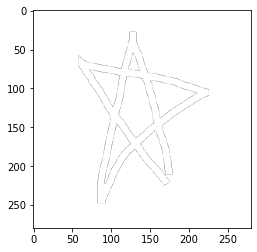

RGBA
(28, 28)


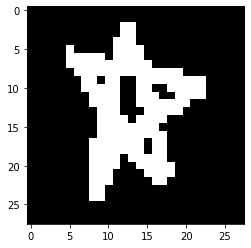

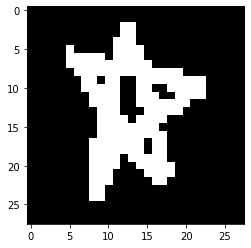

['grapes', 'ladder', 'anvil']


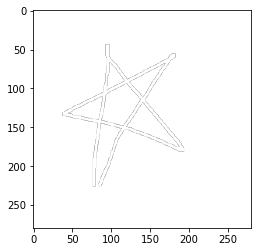

RGBA
(28, 28)


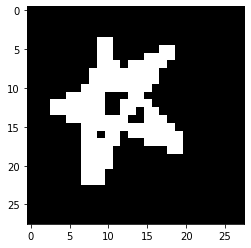

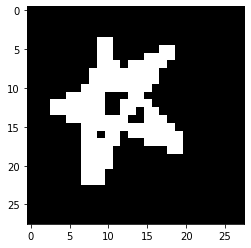

['grapes', 'dumbbell', 'sun']


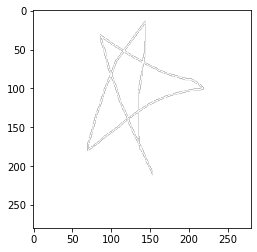

RGBA
(28, 28)


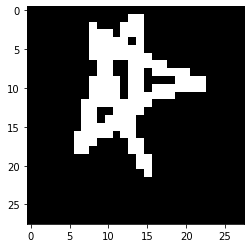

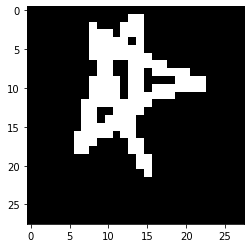

['sun', 'ladder', 'dumbbell']


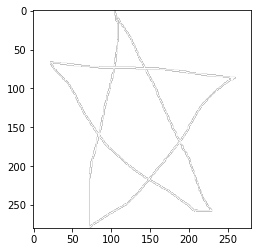

RGBA
(28, 28)


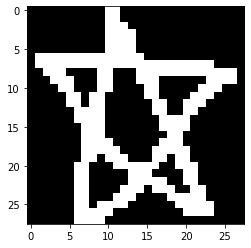

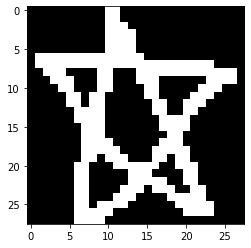

['sun', 'dumbbell', 'ladder']


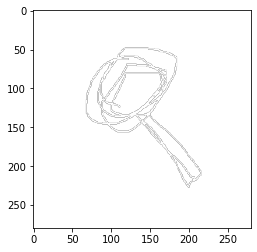

RGBA
(28, 28)


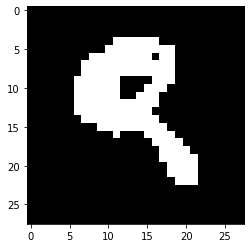

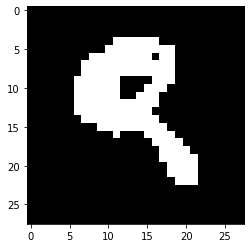

['grapes', 'eyeglasses', 'dumbbell']


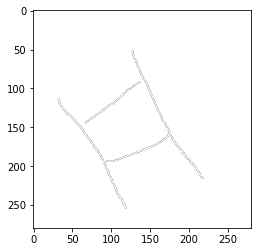

RGBA
(28, 28)


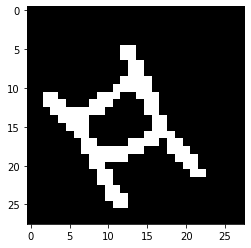

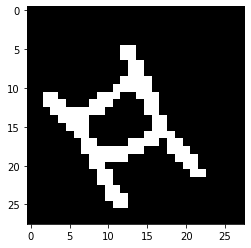

['sun', 'laptop', 'ladder']


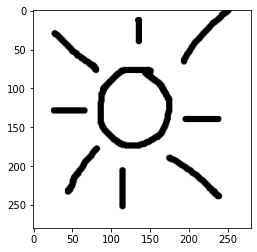

RGBA
(28, 28)


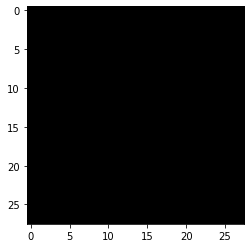

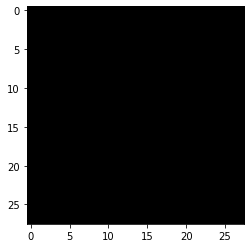

['anvil', 'baseball_bat', 'grapes']


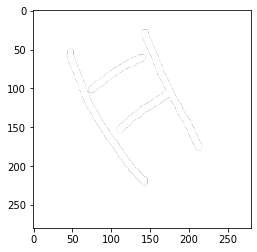

RGBA
(28, 28)


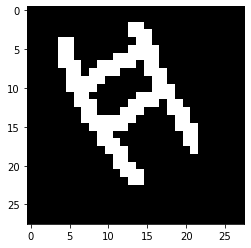

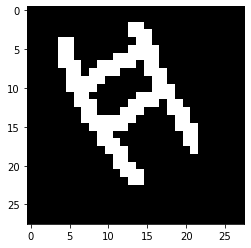

['sun', 'ladder', 'dumbbell']


In [0]:
img_6 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAASRklEQVR4Xu2dy65lNxGGy6fTShBCTTJgghCKkBjwMAx5CV4AiSkSb8BTZMijMEBCSFxGDJIWKEpI34zW7rUP66zeF9vLZVfZX8+SY5fLX9X+d/my1g7CPwhAAAJKBIKSXcxCAAIQEASGJIAABNQIIDBqaDEMAQggMOQABCCgRgCBUUOLYQhAAIEhByAAATUCCIwaWgxDAAIIDDkAAQioEUBg1NBiGAIQQGDIAQhAQI0AAqOGFsMQgAACQw5AAAJqBBAYNbQYhgAEEBhyAAIQUCOAwKihxTAEIIDAkAMQgIAaAQRGDS2GIQABBIYcgAAE1AggMGpoMQwBCCAw5AAEIKBGAIFRQ4thCEAAgSEHIAABNQIIjBpaDEMAAggMOQABCKgRQGDU0GIYAhBAYMgBCEBAjQACo4YWwxCAAAJDDkAAAmoEEBg1tBiGAAQQGHIAAhBQI4DAqKHFMAQggMCQAxCAgBoBBEYNLYYhAAEEhhyAAATUCCAwamgxDAEIIDDkAAQgoEYAgVFDi2EIQACBIQcgAAE1AgiMGloMQwACCAw5AAEIqBFAYNTQYhgCEEBgyAEIQECNAAKjhhbDEIAAAkMOQAACagQQGDW0GIYABBAYcgACEFAjgMCoocUwBCCAwJADEICAGgEERg0thiEAAQSGHIAABNQIIDBqaDEMAQggMBPnQIzxnYiE5d/EGJi6IgESSxGuddMIjPUI+fcPgfEfw+IZIDDF6OiYSACBSQQ1YrMY41sReWCJNGJ0bcwJgbERh25exBijiLwLITzr5gQDD0sAgRk2tGkTWwXmtNOb1oNWEEgnQFKlsxqyJcukIcNqZlIIjJlQ9HOEZVI/9qOPjMCMHuGE+bFMSoBEkyICCEwRtrE6sUwaK56WZoPAWIpGR1/WKiaGEB46usHQgxFAYAYLaOl0qGJKydHvFgEEhvx4JEAVQzLUJoDA1Cbq2B5VjOPgGXUdgTEamF5uUcX0Ij/muAjMmHEtnhVVTDE6Ol4ggMCQFh8Q4OIdSVGLAAJTi+RAdrh4N1AwO08FgekcAIvDs0yyGBWfPiEwPuOm7jXLJHXEUwyAwEwR5vxJskzKZ0aPDwkgMGTFRQIsk0iMGgQQmBoUB7XBnZhBA9twWghMQ9jehuKl4N4iZs9fBMZeTMx4FGP8UkQ+E5E3IYTnZhzDETcEEBg3oerjKMukPtxHGRWBGSWSSvNgs1cJ7CRmEZhJAn1kmlQxR+jN3ReBmTv+SbOniknCRKMLBBAY0iKJAFVMEiYa7QggMKREEgGqmCRMNEJgyIFSAlQxpeTm7UcFM2/ss2dOFZONbPoOCMz0KZAHgKes83jN3hqBmT0DMufPU9aZwCZvjsBMngC50z8/nyQi70IIz3L7034uAgjMXPGuMtuNyPw7hPDDKkYxMiQBBGbIsOpPiqWSPuMRRkBgRohipzkgMp3AOxoWgXEULGuuxhhficjyGocYQniw5h/+9CeAwPSPgWkP1v2WRUAubujyUirT4evuHALTPQQ2HViFY3FuyZGbJ0bc8LUZQwteITAWomDIh80J0dmru8fRVDGGAmjMFQTGWEB6ubMTlqw9FV6t2Stq9sdFYOzHSN3DjbhkCcvWMZZJ6mFyOQAC4zJs9Zw+HzXf22e5NyIPQt4jNOffEZg5436ade17LFQxEyfTlakjMBPmxHa/JYRQLQfY7J0wme5MuVpygdYHgc2SqHi/5dpM2ez1kQMtvURgWtLuOFaM8SsR+XRxoWbVsp8Sy6SOQTY4NAJjMCg1XYoxvhSRF+uFuepVywWBeSsiD5oiVpMPtnQJIDC6fLtbr3VKlDMRqpgcWmO3RWAGjm/tU6JUVBxZp5Iavx0CM2iMe4nLGSdVzKCJlTktBCYTmIfmvcVlYcSRtYdM0fcRgdFn3GyEVidFKRPiyDqF0vhtEJgBYtz6pCgVGcukVFLjtkNgBoit1Tf9s9k7QHIdnAICcxBg7+4xxn+JyI+OPqyoNQ+qGC2yPuwiMD7idNVLCxu6txCy2es8wQ66j8AcBNire413uLTwnc3eFpTtjoHA2I3N3arFy9v8WSY5TLJKLncXGErovEhurv5/F0L4JK93n9Zs9vbhbmFUBMZCFBJ9sL7fcmcvJnqpuBLDQbMEAhYE5vT0Lcl3O1qexWWZGVVMwqdxwCbdBWZNvnfra0pM+GMtzt7F5cyTvRhrmaXvj4kPNPsw1wM9irhQxeh/mC2OYEVgeEnRLjtijN+KyGkTd6SXN1HFWJQBPZ9MCMz67cYm4GavYg25+hvo9FLrsmX2YloT7zueJYGZtopZq5WP19danvRWRF6HEJb/N9y/tYq5+5O0w018wgmZEZhZq5jzN/qoFculz9RI+0oTakbWlK0JzFRVjJfr/lkZldCYZVICpEGamBKYmaqYHi/jtpSzbPZaioaeLxYFZuiLd7sl0d9CCJ/rhdeuZa4m2I1NTc/MCcxaxZwu3o12u3fWJdGVfZgvReQzEXkTQnheM6mxZYeASYEZUWRmXxLd2Owd7ijezse7vydmBWYnMm6/5XZLon+EEH7aP+w2PNiw+W8I4Xs2vMKLmgRMC8xm09flbVaWRPdTlSPr+4w8tzAvMF5PllgSpX0sYozfiMhSvXDxLg2Zq1ZeBMbVydJGXFgSJXwcOFFKgOS0iQuB8bLpG2P8nYj8dvF3pAcUW+Q292JaUG4/hhuB2YnM8p+vLD2rw37LseTldu8xflZ7uxKYVWT+IyI/WIF2P+Kc8VkirWSmitEi28+uO4E5o9p9sJtvEMYYfy8iv7EidP1SqN7IVDH1WFqx5FZgNkLT/HWbm+XQ4obbOzpWknDrB1WMxaiU++ReYNZlU7OXVW1OiLovz8rDbrcnVYzd2JR4NorAqB9j76oWN79JVJIUvfusIm5qE783E6/jDyEwuxOm6pUFVUvb9GaZ1Ja35mjDCIyWyHj8JUXNhGlhm4t3LSi3GWMogdmJzNsQwkdHMPKczBF65X03J4SHY1juBT1rEBhOYLYiU3qbNsb4lYh8utgqtVEjODPboIoZI/pDCszmZClLIGKML0XkxYgvu/KYrlSQHqP21OeRBeZrEfl+zlvxeALaVkLHGLNjaGsGeDOswKxVTNbx9VKWhxAeSAs7BDb7MdVPB+3MclxPhhYYrZOlcdPB5szYj7EZlxSvhhcYRCYlDey34dcg7cfokodTCAwi4zM5t16z4eszhtMIDCLjM0HPXm/2Yni41FEopxIYRMZRZl5wlSrGX/ymE5idyHwdQji/vMpf9Cb0mOeUfAV9SoFZRWZ5xUPWRTxfoR3TW06UfMV1ZoF5JSLLT5Y2fxuerxSx5S17Mbbicc+baQVmu1TieaN7aWLr7+zF2IrHLW+mFpjNUolbon5y9uQpezE+AobAxNj8nb4+UsO2l5s3DP46hPAH297O6930AsO3oc/k5xklH3FDYN6X21kPRfoI7dhe8kN3PuKLwKxxImF9JOxacb4RkWfLCaCIPLBJbzd2CMwmNhuR4Tq63ZxdKs7HfTM2ew0Han1zm20PG3vHEWhj4JnDbb4ETveXuHiXCbBxcyqYC8D5VmychYnD7cVlXS6d98+oOhM5tmyGwFwWmHPS8lb7ltl4Y6xL4nJuTtVpJEgX3EBgrsSG0ttO0m5/VfPahi5Vp514bT1BYG5/a/JAZMe83f1c783b1lw16BioG0MjMLcFhrfad8rbkmsDVJ2dgoXAlIPn6d1ydqU9b+233LJJFVNKXK8fFUwCWzYREyBVanL0t6lKKp9KrmOGTd7yHGATsZxdSs+UjdwUO0sblkqppPTbUcEkMmaplAgqs1nORm6qaZZKqaT02yEwGYxZKmXAutNUQ1i2Q7JUqherI5YQmEx6LJUyge2aawsLInMsPrV7IzCZRFkqZQJbm8cY/yQiv1iff2v2BkH2Y8riVasXAlNAkqVSOrQY40sRebF5sLbpS9bZj0mPlUZLBKaQKkuly+BijH8WkZ9v/nrOsabCwlKpMLErd0NgCoHyzfgU3IVK5dygm7AgMoXJXbEbAnMAJicVpzsnfxGRn/VaAuWEj/2YHFp12iIwBznOKDIbUVnodV8CpYZwW3Uu9/GWF1al9qVdGQEEpozbk16zvGozxvhXEfl89yZEE0ug1DDWvDGcOubM7RCYStEf9WQpxrj8xO5HKyY31cqtsLJ/VinpE8wgMAmQUpuMcrIUY/y7iPzkwjubXVUrd0Tm9OJwfps8NbvL2iEwZdwu9jp/M3r+GY39TVsR+SKE8KuKmEyY2lQx4jleJmDecAKBqRwhr1VMjPH1ZinU7KZtZfxZ5tj0zcJV1BiBKcJ2vZOXKmYVlOUUZZ8D34UQPqmMxaw5Nn11Q4PAKPC1WMXc2FdZ3js89ZEtm74KH4LdqYDeCBNatvRAZIzxnyLy402lMr2gXErJ0td0TpjeWVOmgsnCld6497F1jPFbEfnY00W4dLr1W243fdeK7qH+KPNZRGAUY95jqbT7oCyzG+ZoWTFUj6Z5nKAuZQSmLs8n1lps+MYYvxGR86bsOZ7LMuh1CGGpYPiXSaDHF0Omi26aIzDKodJK1guVyjKTKY6XlUO2PMB5/ulgeB6EjcAcBHive+0qZncRbhmeH32/F4SCv+84s8wsYLh0QWAKweV0O1rFbJ4HelwChRDYhMwJQmFb9mQKwa3dEJhj/JJ6X6pi1sRN6b+NEd+kKcQqtzn6BVHZHVfmEJhG4VqT9FEgNr9geM+DZcP2jyGEX95ryN91CNRe5up4adMqAtMoLr3vxTSa5rDDUMWUhRaBKeOW3cvS7d5s5+nAyVJhDiAwheBKulHFlFCz04eTpfxYIDD5zA71oNQ+hM9EZ06W0sOAwKSzqtKSDcMqGLsb4YsiLQQITBqnqq3W5HzFVf6qWJsa47ZvGm4EJo1T1VZ8+1XF2c3YjD9ZkwsbgcklVqE9a/gKEI2YIJa3A4HAdEhUjqw7QFcakqUSAqOUWsfMcmR9jJ+l3iyVrkeDCqZjprIX0xF+5aFZKl0GisBUTrQccxxZ59Cy3ZalEgJjMkM5sjYZliKnWCp9iI0KpiiV6nVimVSPpQVLLJWeRgGB6ZyVJGTnAFQenqUSAlM5pY6ZYx/mGD+LvfnS+H9UqGAMZCjLJANBqOgCVQwCUzGdjpvi4t1xhtYssOH7PiJUMEYyk4t3RgJR0Q2WSghMxXQ6boql0nGGliywVEJgLOXj42sZQwhUlqYiU+7M7EslErk8d1R67n99QGUQjDYlsIrM2xDC86YDGxgMgTEQhK0L7MUYCwjuHCKAwBzCV78z92LqM8ViPwIITD/2V0dmmWQwKLhURACBKcKm24llki5frLcjgMC0Y508EsebyahoaJwAAmM0QFzSMhoY3MoigMBk4WrbmHfFtOXNaPUJIDD1mVazyM3eaigx1IkAAtMJfMqwLJNSKNHGMgEExnB02Ow1HBxcSyKAwCRh6tdo9mdZ+pFn5BoEEJgaFJVtsFRSBox5NQIIjBraeoYRmHossdSWAALTlnfRaDyfVISNTgYIIDAGgpDiAkfWKZRoY40AAmMtIlf84UTJSaBw8wkBBMZRQrAX4yhYuHoigMA4SgQExlGwcBWB8ZYDLJO8RQx/qWCc5QBVjLOATe4uAuMwAThRchi0SV1GYBwGnqWSw6BN6jIC4zTwm2eU3oUQnjmdBm4PTgCBcRrgTRUj/FCb0yBO4DYC4zjILJUcB28S1xEY54HmdQ7OAzi4+wjMAAHm6HqAIA46BQRmgMCyVBogiINOAYEZJLCcKg0SyMGmgcAMElBOlQYJ5GDTQGAGCihVzEDBHGQqCMwggVymQRUzUDAHmQoCM0ggz9OgihksoM6ng8A4D+DefaqYwQLqfDoIjPMAXnKfezEDBtXplBAYp4G75Tb3YgYMqtMpITBOA3fPbaqYe4T4ewsCCEwLyh3GWKuY5UlrXuXQgT9DvieAwJAJEICAGgEERg0thiEAAQSGHIAABNQIIDBqaDEMAQggMOQABCCgRgCBUUOLYQhAAIEhByAAATUCCIwaWgxDAAIIDDkAAQioEUBg1NBiGAIQQGDIAQhAQI0AAqOGFsMQgAACQw5AAAJqBBAYNbQYhgAEEBhyAAIQUCOAwKihxTAEIIDAkAMQgIAaAQRGDS2GIQABBIYcgAAE1AggMGpoMQwBCCAw5AAEIKBGAIFRQ4thCEAAgSEHIAABNQIIjBpaDEMAAggMOQABCKgR+B+eLy6CxPjqXwAAAABJRU5ErkJggg=="
img_7="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAfGUlEQVR4Xu1dacxuVXV+5FLmy6CMP2qTmta2kbYypAViVWSwUIWoCMigyIwyT4LMg8yDzDJIGGxAoIGWYquUaltoUxBjS5POaTSNFBDhMshwweaB88J3v/u971lrn73P2XufZyc3IXxrr732s9Z53j2u/Q6oCAEhUBMCNwHY29ihzQE8YpQNEntHUC1VEgJCIDcETgdwKIB1jIYtBfBLRtlgMRFMMHSqKASyQIDE8mUAi5zWsN5pzjpucRGMGzJVEALZIECSOCXAmr8D8IGAeu4qIhg3ZKogBLJB4FUAKzqt+RaAHZx1gsVFMMHQqaIQGBSBCwAc47TgWgAHOut0EhfBdIJPlYXAIAhsDeA7AFYwtv5iswD8daN8NDERTDQopUgI9ILAwQCucJDL/QC27cWyBRoRwQyFvNoVAn4EzgBwsrHacwCOAND7qGWufSIYo7dGJLYpAM7V3w9gEh8vAzir+TciKLLqKvHndrSlcEq0ukUwtYwIJjXCZeknuTwEYKUpZvPXk4Gu0h8CiwHcAWB7R5NcyOWPxOBFBDO4C7Iy4G4AO82wiNui08gnq45UYsxeAK4CsIaxP78AcC6AE43yycVEMMkhLqoBDq1XbbFYMdOPS/8UwMccTZFctgHwgKNOclEFS3KIi2pABDO8u7hLdCGA1ZymHAeAZ2OyKiKYrNwxuDFtUyQaqJhJ56ajG3LxtPASgC8CuMFTqS9ZBUtfSJfRDhd5267vK2bS+HJ9AP/rPPrP6dDOALglnWVRsGTplkGN4lx+VlHMpHHPPwD4PYfqswGc5JAfRFTBMgjsWTcqgunfPdc47whdAuCo/s30tyiC8WNWew0RTL8e/hKAc4xNPgvgMAA3G+UHFxPBDO6C7AwQwfTnEh5c5PF/S7kdwG4WwZxkRDA5eSMPW0Qw/fjhEABXGpviwTnrKMeosh8xEUw/OJfUiggmvbc86RZOaE7nprcqQQsimASgFq5SBJPWgSSX+wCsbGjmawAOMshlKyKCydY1gxkmgkkHPcnlXsN1DFrAbest0pnSj2YRTD84l9SKCCaNtzzkwvQY7wbwRBpT+tPaN8Fs1nSt7bRofwiopfkIiGDix4RnWsTW9wdwfXwz+tfYF8F8HsDFANZqurgEwJFDZ9vqH+4iWhTBxHUT7xfxEqLlWyP2xwK4KK4Jw2mzdLqrdSSXaRexvgFgz64NqH5UBEQw8eDcD8B1RnWcFvE5kazSLRhtnyrWB8E8M2fkspAhzzfPL3DFXGV4BEQwcXzAy4s/Mu4W/RzAH9VGLoQxNcFwzeVho794kCibTFxGm2sUE8HE8erfA/h9g6pqySU3gqE9vGdxucEpEkmHgAimO7bWy4vM5bJjjSOXCYSpRzBsh7kqrDlFRTLdg7urBhFMNwStlxdfb94rqmrNZT50fRDMrEXeaa7USKZbkHepLYIJR89zefELTULv8NYKqNkHwRAGPv60jxMPkYwTsEjiIpgwID2XF08BcGZYM2XV6otgiMoBzf6+pkt5x4gIxu+f0Vxe9ELTJ8FMbOOBOx6ysxaNZKxIxZETwfhw9JzSLf7yog+a9NvU0+w5FMBlDmNFMg6wOoqKYOwAeu4XVXF50Q7Nm5JDjGAmNopkvN7qR14EY8PZM3Kp5vKiDZq3pYYkGFrhIZlRbOt5HZhAXgTTDiofoecirfX7qebyYjs0y0pYAfLq9ch7SIbBf7gO43ngdcuKYGZD5jl2Ud3lRW805UAw3pEM5bUm4/W0XZ4jxWlxwQ9mBbuqKiWtB0ervLzo9WguBOMlGU2XvJ62y38fwCZTxB8FwNcfx1qYpJvnXdpK1feL2jo/9+85EYyXZDRd8njaLksCeQjASvOqvAJgSwAkoDEWy7O6xKX6+0Ue5+dGMBOSudQxFNd0yeNxmyw/Jh57364R/3azqDlWciEM3wPwBy3wvdZgVvX9IlsIvSmVI8HQLm4B3u+wTyTj8bpkvQj8MYDdDZX4AoDyGs0BKleC8U6XKC+SMXwBEnEjsDeAmwy1RndK14BJtiOYie3cwvZMlzisP8vScckIASMCTwF4V4vs3wD4oFHfqMRyHsFMHOGdLu2rZOKjiuGUnT3e+KoiMzeOeX1qqg9KIBjvdIk5fhenjDrpHgUCqwH4HwDrtfSWLwYcNwpEAjpZCsF4SYYLxNsG4KEqQmCCwF0APtECx9OG6dOoES2JYLwk87PmtQImu1IRAh4ErAu7nzMuAHvarkq2NIKZkMxXHVvYPMOxfVVeU2dSI9D21A7bvwfAzqkNKV1/iQRDzHne4GoH+EsBnDGWNIUOXCS6PAJ8DPAzLcBwZ+lXALwoAGcjUCrBsFffBLCL08HcFTjfWUfi40GAL5DytnRbOQnA2W1C+nu+J3mtvnkVwIpWYQCUn3/HxlFdohUjYE3DoIVdRxCUPIJhNz3PRExg4TY2c8po8dcRKCMQfRLAuoZ+amHXANJEpHSCYT94BoHZxbwjE21lOwKlclHrrpGuAzgDoQaCmXSZb1tz8XdtBwYvNHeYNJpxgFah6L8A+K2Wft0M4LMV9j1pl2oimAlQ9zbv/XqA05ajB626ZA8EwLekZxVuW69TV7f76U2NBEPkvIu/rMO1mWN03b6fwMuoFctlRpLQtRnZXIwptRLM6QD4PGdI4VTrxJCKqlMcApYnjR8DsHFxPcvE4FoJhvCSZPi8xKIArEfzdnAANrVU2RPALYbO7AGACadUAhComWAmcJBomFfGO4de0kyXdFM2ILAKqMLzLG0xwa3r9QvoS7YmjoFgJuAzKxm3I72FSZyP0NqMF7as5d8D4D8NFvLw3Y0GOYlMQWBMBEMILHPuacHC4XQIQSn48kNgcwD/2GLWHQA+nZ/pZVk0NoKhdw4AcAkAJhTyFs7FOSdXKR8BvWDZgw/HSDATWC8GcGQAxnxU64u6ahCAXF5V+MTItFcq+bBfyOZAXj3MwJoxEwzh/wqAEwL9wBQQXEBWkvFAAAeu9t0Zibr5BtKHBraviubHTjBdp0ys/1cAtqkiGsbVCT4u9yCAled1m29Kb6Uk3nGCQQTzNo7nNXeZ1gyA9s6A3DQBzahKZAT0gmVkQOerE8EsD/B1APYLwH0vALcG1FMVIVAtAiKYhV0bsgDMxd+Qnalqg0sdEwIimOkxwNSaxzpDhI+ef8RZJ4U43/LZAADv0fRZ+AAZyyN9Nqq28kVABDPbN/s0ycXnLwTOqjXE87WTD3uTZmes7anT1BHJHTbmrD0tdUPSnzcCIhibfzgy+bBNFK8ssDNhrOoW41F2PuGyhrtmfxWYBuNgrU/1B3hOLYlg7N5gik3r9KcPXEOmcPbexpfUInh8TLPX2MeHkD0IDgOtI5nUuIYsQju6mUT0cQAbJdEspdkikPpDyLbjHQzj+sKsY+S84zLtCHqHZt+qehuAXWMoGkCH4m0A0IdsUg73o89Ht/iKwbTyKAAe4IpdmLaRI5eSt8IVb7GjInN9cniYg65qFi7n1+YC75YJjpkzoz3XMEouvFzoeSSv5L7K9gYBEUx4KPR1zLzE9ZaFUNUFwvBYK7amCCZv1zHV52UBJnJB9dREmfBnpTmYZipfedgiwcguABpV6RMBEUyfaPvaCiEXZt07GgBzyaYq06aHs9rjwve+Sj+ZyiX56hXB5OmbUHLpK6Wn50zQXISZf4cvPaiMBAERTH6O9pILL1kyMx/fTe6zMGftpwIa5EhGT/UGAFdiFRFMXl7zksvtAHYbsAshJMPpEh+300hmQMf11bQIpi+k29vxkgsTlx/Vrja5RMiaDI3ilv5BWpdJ7p9BGxDBDAr/W417yeUwAJfnYfobVvCVRCbqWiXApgsA6HG7AOBKqCKCGd5LpZPLXATvBrBTAKRDT/UCTFYVCwIiGAtK6WS8h+hyG7kshAxzwPAMjrdwsZovaF7rrSj5fBEQwQznmxrJZYJm232tWajrBc3hYjJ6yyKY6JCaFNY0LZrWYWYDvBDAO02ILCukdZkA0HKsIoLp3ytjIJe5qF4UuNul8zL9x2b0FkUw0SGdqdCbha6ENRcLgkzteaVzl4nnZXgyWU/BWBDOVEYE059jOGXwnGCthVzmIvznAHZwQq5Um07AchIXwfTjDZ4TYU4XK965HKJLgY43cdYSAGulMEQ60yNgDfj0ltTbgveka83kMtfLfwlgO6PbtR5jBCo3MRFMWo9w5MJtV2upcVo0q+88+2I5/atXM60RlJmcCCatQ55zvFnELV3vS5JprU+v3bMuxTzIp6Q3SS3EREAEExPNZXV5Ri9j/oXmC5AnGtzwsnG0Y1Alkb4QEMGkQ/onADY0qh/7GsM9AD5uwEqjGANIOYmIYNJ5g+c4LEVZ3t5E6SXDk7saxVgiKiMZEUw6Z1gIhhf7uG2rApxuXGO5D8COAqwMBEQw6fzURjB8FH5xuuaL1GwZxbBjTFTVd4rQIgEd2mgRTBoPWO7fnADg3DTNF6vVOop5EcDqxfZyRIaLYOI727r1un7i50Xi96wfjdZRjNau+vFHp1ZEMJ3gW7DyswDWbFFLmbXjN12FRitBk4hWraLHFXdCBBPXuZsBeNigUr++s0Gy3jo/GcBZBrwlMhACIpi4wFsIRou7NsxvA7Bri6iwtGE5mJQIJj70bbtH2gGxYW4ha2q6EQDzzahkiIAIJr5T2ghGmNsxt97lIsGQaFQyQ0DBHt8hIph4mFoXfH8KYN14zUpTLAREMLGQfFuPCCYupkzUxax2bYUnovXkSRtKPf9dBBMfcBFMXEz5KgFHKG1Fo5g2hAb4uwgmPugimPiYWm+m6/BifOw7aRTBdIJvucqLACxtUamPwI/5FwBcYai2MYDHDHIS6QkBEUxcoD8M4IEWlSsAaBvlxLWqDm28t3V8S1cUz5n5Wg6J65BrWtIvPAmAIxiVMATaiFnxHIZrslpySFxonwCw3gyVTDHAg3YqYQiIYMJwG6yWCCYe9MTy9RZ1WwP463hNjk6TCKYwl4tg4jmMIxeOYGaVFQG8Fq/J0WkSwRTmchFMXIfpA4iL53xtwjctvtG1i2DiQqoPIC6eIpi0eCbXLoKJC7EIJi6eIpi0eCbXLoKJC7EIJi6eIpi0eCbX3gfB7AGA50PWSN6b7g3wPssRAG4NVCWCCQTOWE34GoHKRSw1wZBcQj/WITHi7d0Qu/UBpPWa8E2Lb3TtqQnGekktesc6KnwcwEYBOvQBBIDmqCJ8HWDlIJqaYNoCIgcMptkQgk1bf0N05oxRn7ZZ0ja8G8CP+zRKbc1GIHXAt31wOfsnBJu2/obozBmjPm27GMCRLQ2uDOCVPo1SW8MSjKZIy+Ivggn/Ijlt3WBG9f8DsGG4etVMgUDqgNcirwgmRtySOPhjNat8tdkBjNGedERCIDXB0ExtU7/trD7wjhQaWam5FMDhLRZxUZ6jHJWMEFDAx3WG1mDi4jnRpulRGlyTaxXBxIVYBBMXT2pbCcDLLWovAXBU/KalsSsCIpiuCC5bXwQTF09q+2UAP2pR+y4AT8dvWhq7IiCC6YqgCCYuggtrS03cmwI4GcBHAXCru5TyLAAmRP9GrgaLYOJ6JvWHENfacrSlxJXk8rcAVi0HjuUs3TNXkhHBxI2qlB9CXEvL0Zb6BO/dAHYqB44FLQ292pK82yKYuBCLYOLiSW2pT/C+WPjoZYJ4lt9ylkbFj9HeNIpg4kOdeotaBBPfZ29pFMHEBVcEExfPPk7waooU12fLaBPBxAVXBBMXz+sA7NeisusJXi3yxvWZCCYRnu8D8M8tuo8DcEGi9mtUm3p6NMFM29SJokcjmHjAWt5F0o1fO96W6dH1APa3q5Rk3wiIYOIiztOk67SofC+Af4/bbJXarmgOkc3qXNfpUZXA5dQpEUxcbxwC4MoWlfrVtWH+DIC1ZohqNGjDcVApEUx8+PkyAQ+HTSsc5fDujMp0BPiyAy8wziq3ANhbIOaNgAgmvn8sOx+3Adg9ftPVaFwCYLGmmuX7UwQT34e/ZlxjOQjA1+I3X7zGLwE4p6UXHCWuW3xPR9ABEUwaJ7dNk9jqC4U8RpcGoelanzPgcjqA0/o2TO35ERDB+DGz1GB+2MMMgrcD2M0gNxYRy+hFxFxQNIhg0jnr5wBWMagnEV1ukBuDiGX0QhI6bwxg1NBHEUw6Lx7YvMltaUEkA1hGL88bFn8teEumJwREMGmBvg/AHxqbGHte2bZzL4RRoxdjMOUiJoJJ7wmuGaxmbGasJGPZ2tfoxRhEOYmJYNJ7wzNVojVjIxlLQimNXtLHaZIWRDBJYF1O6c0A9nI0NZY1Getum3aOHMGTk6gIpj9vHArgMkdzNZPMPk3aCuuVifMBHO/ATqKZICCC6dcRXpKpcbp0NQCeYraWlyrJmWvtb1VyIpj+3Wldc5hYVgvJ8P2eUwEwb46ncA3rWk8FyeaDgAhmGF+MjWT+AsD2AVDrxnQAaDlVEcEM5w0vyZR4reAkAMe05HWZ5oFaRm7DRVgGLYtghnWCd01mKQAueH55WLNbW+ciLgliVsKoWUo0cmmFuAwBEczwfvKSDC3+FoAdhjd9QQvuBPDJDrYpjUUH8HKrKoLJwyPe6RKt/hmAowHcmEEXmJX/YAA7d8zWx0uMvA6gUgkCIph8HBlCMrT+nubDHqInoTtD823l8yRnGfIZD9FHtdkBARFMB/ASVA0lmWcB8FQst4FTl5UAbACAWf8/3qEx5ia+qlmr4X+rVIiACCY/p3qvFcztAQ+lndycGH4lYtd+HcBRzUiJ5NK13AXgU12VqH7+CIhg8vTRAc2IxJKwaloP+KwHD6hdCiB0hHBss84Tg1RoJ0daJKqv5wm7rIqNgAgmNqJx9T0IYMu4KgfRRmK5sFlnGcQANToMAiKYYXD3tMrRzDUASvUVT/Fak255cJFsAQiUGrQFQBvVxD0B8PBZSeVJAMz+3/bSZUl9kq1OBEQwTsCmiG/W/P9H4qhbUAtJhusp1hQHCU2ZqpprPXc3pPLoEAaozbwQEMF08wfXR24A8BuNGn5UPJn7UDe1M2vnOprhI3KeNAwJIZLqXBAQwYR7gkTCEcUK81TwuZJteiCZCwBsGG5+tJpPNDtNt0bTKEXVICCCCXNl24E4jmR4fL6P0vViocdGToE4UuGO0Hua7e//8iiQ7LgQEMH4/W29nLg5gJRrMvMtn6wD/TeAIwBw9ynW+RUu2PKpVp68VRECZgREMGao3hBkfpMzjVX6JpiFzJoc6/+x0eb5Yu8DwAN7JBgVIeBGQARjh+zzzYKupca/AvhNi6BkhEDNCIhg7N61vJtMba8D+EDiRV671ZIUAgMiIIKxgf+dZmfIIl3zcyOW/ktGCLyFgAimPRi4S2O9nKc8su14SmJECIhg2p3NzHFrt4tBIxcDSBIZFwIimNn+ZpY1S4JtpovkhUQVISAE5iAggpkeDlsD4NrL/JO682vcBOBziqpBEOjjDtggHaulURHMwp6cdg1gvjTznFimT7XESw794AlprnVtNYf8lcgqB88sYIMIZnlQrCd1WfMcACdm6tsazSK5MAnXylM692fNvaj/qLHzJfZJBLOs16zTItZ6EcDqJTq9YJuZCmIng/08fXwRAF4IVRkQARHM2+Bz5MLM/FZM9EBY/4HLpObTRi8LWcOLmGcAYCJ1lQEQsH5MA5jWa5OeadEvAJyrqVGv/pk05iWYSb2nABzvOM80SOdqbFQEA3wFwAlG5/IawLYAHjDKSywuAtYp0rRWeWBy37gmSdssBMZOMExpwPwm1qLDdFak0si1LfJaWr0NwO4WQcl0R2DsBPMMgLUMMHLkwhwrlxtkJZIWAZLMNwH8aodmlgDgs7fKwtcBREvVMRPMgcbTt1xzYQpMTYssEdWfDAmfSbAsPxDTrLoDwKf7M3l8LY2ZYJiz5b0Gl2taZABpQBEeLdireXspJIMf04DytUmeyFaJjMBYCYbDYz7ePqtw5HK4pkWRIy6tOi7Anwfg/QHN3APgM835poDqqrIQAmMlGMsN6aMBMLm3SnkIcPGeROO9xsHUoLy0ekp5Xc7T4jESzDGGE54/ALBJni6TVQ4EOO3Z2yE/EeUiMH9grg+oqypzEBgjwVhGLzsD4JBZpXwE+HTtIYHd4NO3XEhWCURgbARj+UXjol/Oz7MGunrU1TiK4TUQ75SJoGmq3CF0xkQw1m1p/Wp1CKjMq94LYMcAG38I4GrnocyAZuqrMhaCsb5nxLl3l3MVQ0QI36qe+4zs4wCO1SGyqa7gaIaL9yGjVOad4Z0mz+nvIWIimzbHQDCe94x4T8Wa4DsHJ5JcbpliCM+G6KTqdC+RKLjgv26AI5UHyAjaGAjG+p7R/c1FRiN0WYj9BMCGUyzhSGajLKzM14jVmh+UXZ0m6nS3EbDaCYZ3VnYxYPE8gMUGudxEGOizSu3+jeUP7jJxt8lTeD+NaT70XvcM1GoOwFnTh/mQlDY1mtgvgvFQwmxZT9qOuZp4O5vxwwyHKvMQqJVg+FgaD0m1vQhAOLgAfHahkSGCies4ngA+P2ChXyeAp/ihRoKx7hgRktLfMxLBxCWYiTYeaWBs/I5TvU4Aj2AE8yqAFQ2BUcN7RiIYg6M7iBwJ4ELjSHhuMzpL1aBR2wiGW8ycHlnKxgAeswhmLCOCSe8cpoPgDqPnW9EuU4UEY7kGMAlHjnJWSh+byVsQwSSH+I0GeB/pVGdTSvfhZGUnvr2Kc9TiOSDH6/hn9mphmsZEMGlwXUjrfs1bS2s6mxx1wjLPsM+Ja6/i3CJc1dAiP0huKd5okC1BRATTv5f4zhLfxFrP2DR9xHM2zDMzulIDwfAB9IeNniv1vMu07olgjI6PLBZyAvhPAHwysh3Zq6uBYG4AwPtGbaXGlxhFMG1eT/t3jkz40oTlvBUt4YlxpmH1TOfT9iCx9hoIZimARS04Mf8uj3XXVkQww3vU8575xNqSD3e6EC+dYHgYqu0uyAsA1nChUo6wCCYPX3meHqbFo9nGLp1geHKy7ZIiT2Vem0ccRrdCBBMd0mCFISRT/asVpRNM2wfGaCm9j7Mivq3/Nfc9mAkSVvRcU5mYUfU2dukB2PaBiWASfk1SvSAC3HBg/l/PtLxakqmdYJjiMCTRcynfThvBlu7fUvywkJ13AfiEowNVkkzJAcir9W25UU8AcK7DyaWJimDy9hjX/7gJYd3GPhnAWXl3yWddyQTDMwWrt3R3fQDM1VFrEcHk71nvNnZVh0FLJRhmEWvLo1rLhUYt8uZPIm0WenaYeO2l7Yezrb1s/l4iwVgvNvK0JH8Nai4awZTjXQ/JvNIkvCr+xG+JBGNNKLU5gEfKib8gS0UwQbANVslDMjSy+OstpREME/98xBAeVQ0zZ/RXBGMIhsxESDLcxrZ+e0W/wWTtZA4+spILba1qoUwEk0P4RbWBIxM+RWstTBHhTXhl1Z1UrhSC4VYf7x1Zys0APmsRrEBGI5hyncj8MNzGthauy3ALu6hEaaUQzGuOswSl9MkaWLPkRDAxUBxOx1MBb2TzpHAxCdNK+RjbPqRJiNR+cnf+p9CGSyn+He4TH7Zlz+OAE0t/Gvie9iA9LSUA2z6kCXhje/C9DZdS/DtI8GfSKJ9G4WlzTxL6Yp7cKSUA2z4kxgoXzZhhbEylDZdS/Dsmn03r6yUAjnAAcS+AjznkBxEtJQDbzr6MkVwYMCKYQT6bZI1y+vNOh/Z/Cnh90qG+u2gpBDMrz8adAHbpDkWRGkQwRbptqtHWU+pzFTwNYDsA388RilIIhtiRZPhv5QbIl5ttu6punzqDRATjBKwAccY4b1V71mQ4wt8iR5IpiWAKiI3eTRTB9A55bw0+A2AtR2v3ANjZId+LqAimF5iTNSKCSQbt4Iq9W9gc0a8yuNXzDBDB5OYRnz0iGB9epUmTZK4zEocIpjTvFmCvCKYAJ0Uw8YcAfrtFj6ZIEYCWimUREMGMJyJ+AOB3p3RXi7zjiYNeeyqC6RXuwRtjDur956V6+DcAe+S4g0S0tAYzeMx0MkAE0wm+Yitv1liefUI1EUyxMfaG4SKYsv1XvfUimLJdLIIp23/VWy+CKdvFIpiy/Ve99SKYsl0sginbf9VbL4Ip28UimLL9V731IpiyXSyCKdt/1VsvginbxSKYsv1XvfUimLJdLIIp23/VWy+CKdvFSwEsmtIFvsSwYtndk/WlIyCCKduD3wXwwSld+B6AD5XdPVlfOgIimLI9uCmAB+dk+Zv0hlf3t8r1fkrZkMt6DwIiGA9aecqSZJhikXlZWb7dvP6XZY7WPCGUVakQEMGkQlZ6hYAQ0G1qxYAQEALpENAIJh220iwERo+ACGb0ISAAhEA6BEQw6bCVZiEwegREMKMPAQEgBNIhIIJJh600C4HRIyCCGX0ICAAhkA4BEUw6bKVZCIweARHM6ENAAAiBdAiIYNJhK81CYPQIiGBGHwICQAikQ0AEkw5baRYCo0dABDP6EBAAQiAdAiKYdNhKsxAYPQIimNGHgAAQAukQEMGkw1aahcDoERDBjD4EBIAQSIeACCYdttIsBEaPgAhm9CEgAIRAOgREMOmwlWYhMHoERDCjDwEBIATSISCCSYetNAuB0SMgghl9CAgAIZAOgf8HcrJDVZ1U03YAAAAASUVORK5CYII="
img_8="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAeyElEQVR4Xu2dedhuVVnG75sUZy0QlMwCK72cNdFUspTAIefMMgWVQQEnJhllSEZFBEWZFEURUcmcp0BEvURNJWczy8TSRBRMBNRE7q7nsA+dc/i+d629373fd+217/XP+eNdw7N+zzr3t/deaz0P4WICJmACAxHgQP26WxMwAROABcaLwARMYDACFpjB0LpjEzABC4zXgAmYwGAELDCDoXXHJmACFhivARMwgcEIWGAGQ+uOTcAELDBeAyZgAoMRsMAMhtYdm4AJWGC8BkzABAYjYIEZDK07NgETsMB4DZiACQxGwAIzGFp3bAImYIHxGjABExiMgAVmMLTu2ARMwALjNWACJjAYAQvMYGjdsQmYgAXGa8AETGAwAhaYwdC6YxMwAQuM14AJmMBgBCwwg6F1xyZgAhYYrwETMIHBCFhgBkPrjk3ABCwwXgMmYAKDEbDADIa23o4l7QDgFQDu2MzyUgD7kTy73ll7Zl0IWGC6UJtwm0Zc3rIKgh0tMhNeHCtM3QLj9dCKgKQfrPPksmHbS0lu0apDV66agAWmavf2PzlJmtUrSa+p/rGPtkcvhtG6bjmGW2CWw32so1pgxuq5JdltgVkS+JEOa4EZqeOWYbakewH4amLs/UnGDpOLCcAC40WQTUDSZgAuSzT4Icm129fZfbtinQQsMHX6dbBZSQqBCaGZVe5G8luDGeGOR0PAAjMaV5VhqKTnATg5Yc3rSO5WhsW2YpkELDDLpD/SsSVdDmCTGeb/iOTmI52eze6RgAWmR5hT6UrSGwHslJjvbiRfNxUmnufKBCwwXhmtCUi6D4AvJxr+EMBdSF7TegA3qIaABaYaVy52IpJCQFKvQR8n+YjFWubRSiJggSnJGyOyRdILAZyUYXLcsj4+o56rVEjAAlOhUxc1JUkXANg2MZ4/+C7KIQWOY4Ep0CljMUnSLQF8e8bt6rVT2YrkJWOZl+3sj4AFpj+Wk+xJ0i4AzkhMfneSp08S0MQnbYGZ+ALoY/oZ52LeQHLXPsZyH+MiYIEZl7+KtFZSnHd5zgzjfkwydb2gyLnZqPkIWGDm4+fWACTtDOANCRjbkrzQwKZFwAIzLX8PMltJdwAQgb9nlfNIPmoQA9xpsQQsMMW6ZlyGZR68ewTJj49rZrZ2HgIWmHnoue0NBCS9BMBRCSTvJ/kEY5sOAQvMdHw9+EwlfQ3APRMD+SlmcE+UM8AoBcaJv8pZQOtaIunhAFIfcv0UU6b7BrFqdALjxF+DrIPeOpX0PgCP91NMb0hH3dEYBcaJvwpecplPMV8meb+Cp2HTeiIwRoFx4q+enD9UN5lPMXuTfNVQNrjfMghYYMrwQ1VWZD7FOM1sVV5feTIWmAk4eRlTzAzl8CCSn1+GfR5zMQQsMIvhPLlRJD0GwIcSEz+N5B6TgzOhCVtgJuTsLlOVdAqASEGy0TrtvwlgB5IXz+pT0qwP8tH0CpKbdrHLbcZBYFQCk5lZ8CYkfz0O/GVbKelzAB64ipW/AvCQWSIj6SAAxyRmeSTJw8omYeu6EhibwIS91yUm61u7XVfD9TejtwbwaACHAtg40dV7ST4p8RTzIwC3n1HHqWbn8FfpTUclMAEzI3Wpgxu1XHVNUvuIrXssgAiDmVt+TnJmfUmxFb1nosM7k/xe7qCuNx4CYxSY05pvAqtRdnCjzPUn6ZDMJ5XVeswRmLsD+EbCpINJhri5VEZgjALj4EY9LEJJLwUw77eP5CtS89QZsWIiZsxq5QMkU9cLepi1u1g0gTEKTE5wo38heY9Fwyx9vOYjeewIvRjA7ea0N05UPzC1k9QIzHEA9kuMtynJK+a0yc0LIzA6gWkWbE5Wwf1JvqIw3ksxR9LRzWtln1vCh5JMxX9ZM19JmwC4PDH540gesBRAHnQwAmMVmJzgRpPfnZAUTyuvBHCrHlfQ/wLYheTZbfqU9H4Aj5vRZvL+asNzLHVHKTDNX8V/BXDXBOi7kfzWWJzRp52S3gngKX32CeA7JO/Spc/MiHf3I/nlLv27TZkExiww2wM4L4H1cJJHlIl+GKskvRzA7gBu2+MI8b0ljvU/r2ufkrYMgUq0P4PkrPQnXYd3uyURGK3ANE8x3p1oFk7zOnQigFv0sJZ+CmAfkm/soa8busi4OnAVgM1J/rzPcd3X8giMXWDiGHocR59Vqt+dkBTfQ57R0zI6guThPfW1XjeS4nRw6onyRSRfM8T47nPxBMYuMDm7E8eSPHjxaIcfsXlqidvI9+1htPh4exTJI3voa9UuJMWJ3TvNGOO/Sc76fUjz3HfPBEYtMM1r0uR2J5oPpgcCuPWc6yFeheJp5QKSkRFg8CLphQBOSgx02NBCN/hEPcAaAjUITJxGjVOps8ojSZ4/dp83Ac9Pb3lfaMNpvxXAmlCVJL+waCaS4hvRZQlxdLS7RTtmoPFqEJg/BJDaiv4oydh1Gm2RdC6Ap84xgfhwGnFwQ6CWWiSdEWdpEkZsRfKSpRrqwecmMHqBCQKSUrtJUW2UCb+axPKvnuN16EoAp5Pcf+7V0lMHkuKb0ZcS3R1CMk4gu4yYQC0CE/dc4r7LrPIVkn18DF2Yu5vbzvN8dH0nyXmeegaba8YfBV+AHIz+4jquQmCap5ivALh3At2+JE9YHN7uIzU7RBGaokuJp5a4i7X016HVjG8OBKaeqqo/YtDFuWNqU5PA5KQtHcV9F0nxIfbpHRZSHLM/tWRhWTunzAuQ1R4x6ODbUTapRmCap5iPAvjzhCeKve8i6VkA4gkrzve0LSeQ3Ldto2XW9wXIZdJfzNi1CUzEkv1wAt2JJPdZDN68USRF2MlzADwxr8V6ta4GEKdfez3W38GO1k0kTeaIQWs4lTSoSmCap5jUjlJReZElxdH5uJy4Wcs19a6IobuMsywt7Vy1uqRJHDHoi9cY+6lRYHL+Km5D8tPLdJikXZsDb11itexBsusH4GVO+0ZjZ+wmRZtRHjEoCvSSjKlOYJqnmLiVO+s/7skkX7Ak5nFu5/UAQmC6lKrOh0jKOWLwRZJ/1AWW2yyXQK0C81oAz5+B9hqSXZ4c5vZW5o3ilcYJ0dxzjN9aUtAk5RwxeAHJk1N9+feyCNQqMA8FcFEC9WBhCVYbV1JcUOySnuMfScYH7CqLpGqOGFTpoDkmVaXANK9JcRR91sndhV6ok5TK57SSGyNQdgR+OmsOH4+iqaQLAYTQzCpPJvmeUUzIRq4hULPAREaBSM8xq2ydk3ZjnrUiaXMA7wXw4Bb9RLrVV5KM8JeTKJJiiz4lHp8gmRKhSfAayyRrFpjIi/T1hCPOJBmJ3AYpzU5RfA+6WYsB3t5E7b+mRZsqqnpHqQo3rjeJagUmZrnMGLCS4lTt8S2XzEkkU3mcW3Y5nuqSYmcvFS7TO0rjcWm9r0iNwOTkT+o9BqykSCQf1xZyBTzCVT6fZMRJmXSR9M8A7p+A4B2lkayS3P8AI5nOjc1cVAxYSQ9q/mM8BMCOADbKhPbZuCJAMqK8Tb54R6muJTAFgcmJAdt5y1pSpDuNoOJd8hBFIKi4JuCyDgHvKNWzHKYgMDkxYDuFcZCUOtA3a6UcRPJl9Syl/mbiHaX+WC67p+oFpvkW8zoAqYyBW5CMi5JZJTM6/mp9OWp+grJ3lLKWYfGVpiIwEekujqPPKvGR9ZQcj80hLtcBeGHuODm21Fonc0epqJvxtfpinnlNQmCap5gfRlrSGbAiElwy9/Ic4hL5nbcj+bF5HDaltpk7SnuRjKDoLgUSmJLAxEW5WQLybZJ/MMtHc4hLdLvUG9wFrr2kSZk7Sgu98pE02hXWIzAlgbkXgK8m/H/v1TIcSto7ju+3ONuydqgIwH3MlI799/l/TFI88T0i0efDSH6qz3HdVz8EJiMwzWvSvwP4/RnoTiG5XpgHSTsBiHtNm2Yij1ehuJz4GQBx6vRzme1cbQUCkh4L4AMJOG8h+UwDLI/A1AQmPuJGsvjVymUk77D2x46xW3o/GVzeslmsRcu88rHYmdY32tQEJr7BpIIW3Zfkmh0nSb8EsHELt1tcWsDKrSopbsXHU+SsYva5QBdYb2oCE08nqbMuryf5XEk532zWdZUX+IALV9J/ArjzjCH+i+TvDmiCu+5AYFIC0zyVpLIORGjK2M6+NYDc+0EWlw6Lr02TzB28yGaZetJpM6zrzklgigLzUgCReSD5uJ3x7h99OPvgnIsw1VzSDgDipnkqro63rFMwF/z75ASmeYr5PoDfnsH6+yR/p9lBWi2hWTzpvHgMaVoXvKZ6Ha4Rl7e06PRxJD/Yor6rDkhgqgKTc8P6JSSPaXaSDlnnY2/EyY1b0BFrxmVAAo24xJZ/m3V6IcmIx+NSAIE2jivA3H5MkJRzw3q9x+3mo2/cuo54uS4DE5B0OoDndhzGido6guu72SQFpnlNilefOEQ3q9yT5Df6hu7+ZhOQ9GYA8xycu5jk1ua8fAJTFpjIFHhxwgXHk4zMgy4LINB88zo142NujjXPIxl9uSyRwGQFpnmK+QGAO87g73AAC1qcPTy1bGjpeqeyFzQND7MBgakLTM6W9TYkP+2VMwyB5kNu5Oq++QAj7EYygo25LInApAWmeYqJ7eZZeaodZmGgxSnpAgBdd3zeBeAvE6b9B8lZl1sHmpm7XUvAApOOq3sNyVkC5NXUgYCkuCEdN6W7lLXXOVKnsqPvAx0qowviftpYYKSHArgogbNz1oF+3FRPL5Jidydi6zy9w6yuBrA7ybObp8+Is5x6Bfp5hOggGd/bXBZMYPIC0yzULwG47wz2PoI+58JsdohOau54dentFST337Bh5mvWR0g+psugbjMfAQvM9WEZ4oJchASYVbYmmdrWns8blbaWdByArtv9kfVyD5IrXtmQtAWAbwOIw5Ozys4kz6wUcbHTssBcLzD3APD1hJfOJLlzsZ4s1DBJbwfwNx3N+yDJx6XaNsnvUjmmriCZG5UwNaR/zyRggWlAZdycXhPGgWS807skCEjarYlh3PUDeas7RZK+A2DLhFkvJ3mgnbc4AhaY/xeYuLx4VAK9475krE1J8RH2GRlVV6oSMY1Py0khs25jSXsCeFXGmH7VzYDUVxULzDokJX0PwJ1mwL2E5FZ9wa+pn+bAXPwHn+c15ESS+3TlIikuot4+0f6TJP+s6xhu146ABWZ9gckJ47A3yZy/lO08MdLajbDEzedbzjmFFXeJ2vQpKS5IxkXJVMn6tpPqxL+nCVhg1heYnDAOPyG5SRpt/TUkxWnaJ8850/i2tedqu0Rt+5b0NgBPy2i3L8kTMuq5yhwELDAbwMtcoK8h+aI5uI+6aXOmJVLAzHN/6EMADif5hb5hSPoEgD9N9Ptjkpv1Pbb7W5+ABebGAvMXAHJCLj6Z5HumtqDm/IAbuK4BsM+QoUYlPQBAjnDdleS/Tc2Hi5yvBWYF2pIim0Dqr1vE9b3/VCLcNdvOx89xEjdIf5hkCPjgRVLOrmAc4DttcGMmPIAFZmWBybnjEi3PJdn1ENlolp2kYwAcNIfBcYcovnnEx+CFFUk/AfCbMwZcc2lyYQZNcCALzCpOl3QOgL/NWBNV50XOzEc0C9P7SD4xg2PvVTLi+vp0b+/U/Q0mG6mkdwD464wGO5F8U0a9UVWRFLsscfO5S1nv5nOXDuZt07zWpV6BdiX5hnnHcvuVCfgJZsbKkBTfYb6YOHwXPVS3IzHHk8uVAJ6/NqTCMv/jSYqrA3GFYFaJmDIRziE+Prv0TMACkwAq6UkA3p3B/Zkk2yQIy+hyOVUkRZS58wFs1MKCXwKIQNurJapr0VV/VTM/2H+A5OP7G9U9rSVggclYC0pHvYtePkXyYRndFV1FUrwSxW5RrrjEX/5Xkzy4xIlJijAcOfmqq3zNXbZPLDCZHpB0BYDfSlQfbcKv5pj9vgDuk4kkqr2KZNdvNC2Gma+qpAsBPDzRS3WvufNR66e1BSaTY+YHw9El/JIUMW5ennFJcENSo7lZLinuSV2ScbZpP5Lx9ObSEwELTAuQkv4JwIMSTUaT8EtS7J50CaI1163nFsh7q5r5qhS3sbf0B9/esLdKKt7fqCPtSVI8Zsfj9qwyioRfkv4hI+3HhvO8DsBeJF8zRhdmhnN4N8lUOpQxTn8pNvsJpiX2zIt0xSb8ai4qvrZDeIUIBLUdyY+1RFZM9WbuObtczyJ5VjGGj9gQC0xL50n6KwB/n2hWZMKvzNi1q03t2FJ3itq4UNL7AaTi/P6U5KwrBm2GnHRdC0wH90saXcKv5mzLR4HWr8U/BXDAou8RdXBLVpPmg+93Mz5qn0Oya9jPLFumUMkC08HLknIuQxaT8Ks5lRtR+HLPtgSVrwF4bS3Csq6bM29aR5M3ktylwxJxk4aABabjUhhLwq8OR/7jiWX/2pPGS7ocQE5kwl1KO53ccckupZkFpiP2MST86vBadBbJZ3VEMqpmkmKeORdUfQBvDs9aYOaAl/nRdCkhATq8Fk0uZ5CkuGkd+ZtSxbtKKUKr/G6B6QhubbMSE361fC2Ksy1x+zkV1mBOUmU2lxRZCCIbwazyJZL3L3MGZVtlgZnTP6Ul/GquNJyauVsU4rL9mM+2zOm+Nc0l/Q+A2yX6KvZsUx8MhurDAtMD2cwTooMn/OpwOnc094l6cNOqXUiKsJmpcJ6XktxiSDtq7NsC04NXWyT8GiS8ZnNh8dUtAnLHqdzIRTTKI/89uOxGXUj6LIA/TvQducnjvpJLJgELTCaoVLXMfErRTa+BqSQdAuDIlH3r/O7XohVgZd4zO4NknIFyySRggckElVMt855Sb5khW37MXTsFvxatLDBbA/h8hp93r/HwYca8O1WxwHTCtnKjFgm/XkkyIq11LhaXzuhWbCgpV2CuIXmrfkevtzcLTM++lRQBiyIyXKpsTfLiVKWVfm+5U7S2i0NIHt1lvKm0ydxNChzHkTxgKlzmmacFZh56q7TNDK/ZaVep+aDbJs1Gr8nlB8BVTJct2F5JMrWtXcy8lmmIBWYA+pJ2BJATT+TtJHOSu91gZYu/stHmXSSfMsAUq+2yxdPhaST3qBZETxOzwPQEcsNuJEUKkx0yus8+ht7iO0FsQ0fozkmezs1gPrOKpEMBHJHRz84kz8yoN9kqFpgBXZ+5q5R9ma6FwHinaE6/Sopb5bdNdONXpQQgC8ycC3FW8xa7ShHnNg7KJYukXyfiulhckhTTFSQdB2C/dE08kOQXMupNsooFZmC3S3pZRIRLDHMJya1yTJH0SQCrJXi7iOSf5PTjOmkCkiK/dqQ8mVUsMDPoWGDS62zuGpnBjQ4kGfmJZpbmqegiADfboGKkbt2m69Z3atwp/i7pIADHJOa+KclIyueyAgELzAKWRWY0++wQm43IxIfIRzfmfySuC1hc+nWmpI0BhHDPKh8i+dh+R66nNwvMgnwp6cPrCMJqozoJ+4L8kTtMZoB3Xx9YBagFJnelzVlvDCE255xilc0lvR7AronJ+fqABWb56z8zxObPANyJZPzrsmQCTVzjCzLM8PUBf4PJWCYDV8kMsen3+oH90Kb7zDMxV5O8dZt+p1DXr0gL9rKkOFsRZyxS5WiSEevFZckEJO0F4MQMM15K8u8y6k2migVmCa7OvAwZlr2MZGyVuiyZQGbK2ctJ3n7JphY1vAVmCe6Q9GwAuXdYdiKZk79nCTOZ1pCSfgIglbP6biS/NS0yq8/WArOklSAp4uG+IGP4OB+zJcnLMuq6yoAEMl+V3k/yCQOaMaquLTBLdJekowC8JMOET5PcJqOeqwxMIDNchm9ZN36wwAy8IFPdSzofwHapepFWg+TuGfVcZUACkuLVNl5xZ5WrSN5mQDNG07UFZsmukhQL8dKMS3Vh6UEk4/Kky5IItDgX40uQmdn/luTK6QzbIhF7QDmZZM63m+kAXPBMJcUhyNSZl7eSzAk4tmDrFzucn2AWy3vV0Vp8j4k+nkPyjEJMn5wZLXJRTf5bjAWmoP8ekg4EcGyGST8jmYq2ltGNq3QlICl2926eaH8tyZt2HaOGdhaYwrwoKeLo7pZhVoRnOCyjnqsMQEBSpIA5OKPrC0lum1GvyioWmALdKulCAA9PmPZTkqlDXwXOrh6TMiPegeRk/59NduIlL3NJmwO4BMAtEnYeQzLnHE3J0x2tbZIi2l3OVY7J7ihZYApd3i1SZ3TOEFno1EdllqRfrBC+dMM5WGBG5dWJGJt596VThsiJIBx8mjnZIP2KNLgbPEAXAjmLt+n3bSSf3mUMt5mfgKQfALjjKj19l+SW848yzh78ilS43ySdC+CpGWZmZ4jM6MtVWhBogrB/FsBNNmh2LYAHTzkYuwWmxUJaVtXMDJGORbIsBwFwpoeV4Vtglrgoc4dukSEyK7dS7riuZwLzErDAzEtwQe0lRVK2/RPD/RjA75G8ZkFmeRgTmEnAAjOiBZKZIfIdJJ82omnZ1IoJWGBG5NwWt66fT/KUEU3NplZKwAIzMsdKeg+AJybMvg7A9iQ/NrLp2dzKCFhgRuZQSbdsrhFsljBdAI5wGo2RObgycy0wI3SopCMAHJppumPHZIJytf4JWGD6Z7qQHjOzDYYtV5K83UKM8iAmsAEBC8xIl4SkSMgeidlzimPH5FBynd4JWGB6R7q4DiVFmtIIOpXy44+a3Eo+H7M493ikjIVpSIUTaKLcR+qTjRKmvpfkkwqfjs2rjEDqL19l061zOpKeF9kGMmb3bJJvzqjnKibQCwELTC8Yl9+JpLcBSJ3gvYLkpsu31hZMhYAFphJPtzgfcw7JZ1QybU+jcAIWmMId1MY8SQcAyMn8uDvJ09v07bom0IWABaYLtYLbSIob1anXIF8lKNiHNZlmganJm9cHPnomgJwPuXGV4DCSR1WGwNMpiIAFpiBn9GWKpI8AeFRmf7uQfGNmXVczgVYELDCtcI2ncmaC9pjQVSRvM56Z2dIxEbDAjMlbLWxtkZEgev0oye1bdO+qJpBFwAKThWmclSRF1scjM09s70zyzHHO1FaXSsACU6pnerKrxVWCn5DcpKdh3Y0JrCFggZnAQpC0O4BTM6Z6PslHZtRzFRPIImCBycI0/kqS3gTgWRkzuQrAnt5ZyiDlKkkCFpgkonoqZOa6XjvhQ0geXc/sPZNlELDALIP6ksaUdCyAA1sMfyzJg1vUd1UTWI+ABWZiC0LSLwFs3GLavrfUAparrk/AAjOxFSEpskNGlsjc4oN4uaRc70YELDATXBSSIiNBhNq8Seb0zyOZe/Ugs0tXmwIBC8wUvLzKHCWdC+CpmQiuBXAMycMz67uaCfgczNTXgKTdmjMyuX9sIpmbRWbqCydz/rmLKrM7VxsjAUknAtgr0/ZrSd40s66rTZyABWbiC2Dt9CVdDSDS0uYUh93MoeQ6fkXyGrieQPOqdFoLHieS3KdFfVedIAE/wUzQ6atNWdL7ADy+BZJ46olzMme3aOOqEyJggZmQs3OmKum5AE4CcLOc+k2dC0hu16K+q06EgAVmIo5uO01Jv2gpMqeSjARwLiZwAwELjBfDigQ6fJO5juRvGKcJrEvAAuP1sCoBSWcB2DEXEUmvp1xYE6nnBTERR3edpqQTAOyd094Ck0NpWnUsMNPyd6fZSoo8S5FvaWaxwKQITe93C8z0fN5pxpIuALDtrMYWmE5oq25kganavf1OTtJlADZbpddvkrx7vyO6t7ETsMCM3YMLtF/SAwB8BsCGd5F+BeAhJC9eoDkeagQELDAjcFJJJjYiE/Fk1mYfOC9yL1lcSvJSObZYYMrxhS0xgeoIWGCqc6knZALlELDAlOMLW2IC1RGwwFTnUk/IBMohYIEpxxe2xASqI2CBqc6lnpAJlEPAAlOOL2yJCVRHwAJTnUs9IRMoh4AFphxf2BITqI6ABaY6l3pCJlAOAQtMOb6wJSZQHQELTHUu9YRMoBwCFphyfGFLTKA6AhaY6lzqCZlAOQQsMOX4wpaYQHUELDDVudQTMoFyCFhgyvGFLTGB6ghYYKpzqSdkAuUQsMCU4wtbYgLVEbDAVOdST8gEyiFggSnHF7bEBKojYIGpzqWekAmUQ8ACU44vbIkJVEfAAlOdSz0hEyiHgAWmHF/YEhOojoAFpjqXekImUA4BC0w5vrAlJlAdAQtMdS71hEygHAIWmHJ8YUtMoDoCFpjqXOoJmUA5BCww5fjClphAdQQsMNW51BMygXIIWGDK8YUtMYHqCFhgqnOpJ2QC5RCwwJTjC1tiAtURsMBU51JPyATKIWCBKccXtsQEqiNgganOpZ6QCZRDwAJTji9siQlUR8ACU51LPSETKIeABaYcX9gSE6iOgAWmOpd6QiZQDgELTDm+sCUmUB0BC0x1LvWETKAcAhaYcnxhS0ygOgIWmOpc6gmZQDkELDDl+MKWmEB1BCww1bnUEzKBcghYYMrxhS0xgeoIWGCqc6knZALlELDAlOMLW2IC1RGwwFTnUk/IBMohYIEpxxe2xASqI2CBqc6lnpAJlEPAAlOOL2yJCVRH4P8A5QaVkVLa4WUAAAAASUVORK5CYII="

for i in [img_1,img_2,img_3,img_4,img_5,img_6,img_7,img_8]:
  print(getresult(i,model2))


In [0]:
!python3 -c 'import tensorflow as tf; print(tf.__version__)'

1.15.0


In [0]:
!python3 -c 'import PIL as pil; print(pil.__version__)'

7.0.0


## Look at the test data - to Try

In [0]:
def show_batch(x_test,y_test):
  idx = [ randint(0, len(x_test)) for i in range(10)]
  fig,axs = plt.subplots(nrows=2, ncols=5, figsize=(9,6))

  for i in range(2):
    for j in range(5):
      pos =  i*j + j 
      img = x_test[idx[pos]]
      ypos = np.argmax(y_test[idx[pos]])
      axs[i,j].set_title( str(ypos) + " " + class_names[ypos] )
      axs[i,j].imshow( img.squeeze() , cmap="gray" )

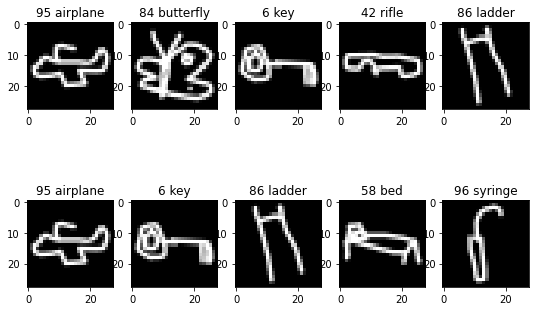

In [0]:
show_batch(x_test, y_test)

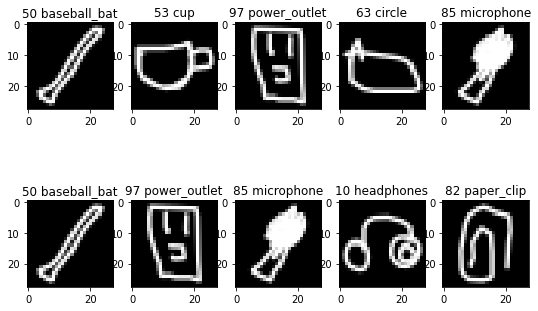

In [0]:
show_batch(x_test, y_test)

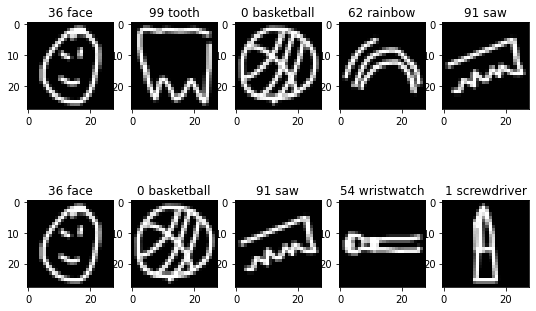

In [0]:
show_batch(x_test, y_test)

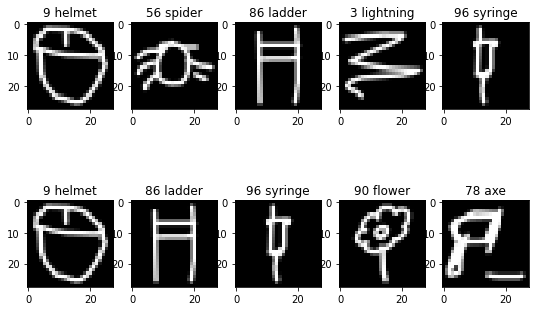

In [0]:
show_batch(x_test, y_test)

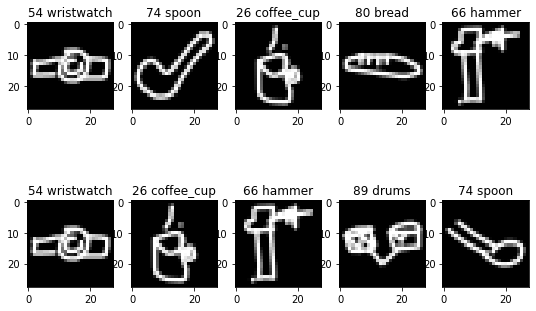

In [0]:
show_batch(x_test, y_test)

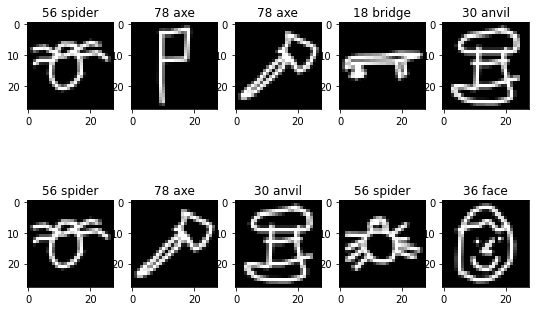

In [0]:
show_batch(x_test, y_test)

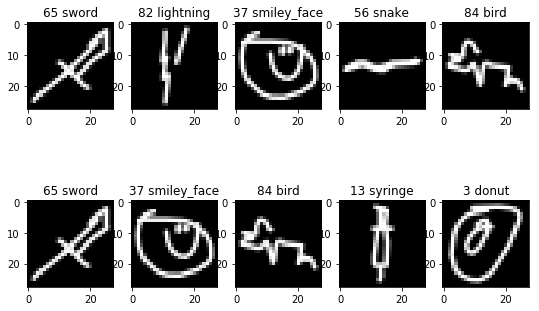

In [0]:
show_batch(x_test, y_test)

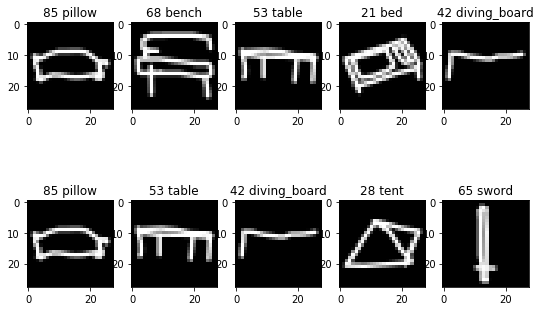

In [0]:
show_batch(x_test, y_test)

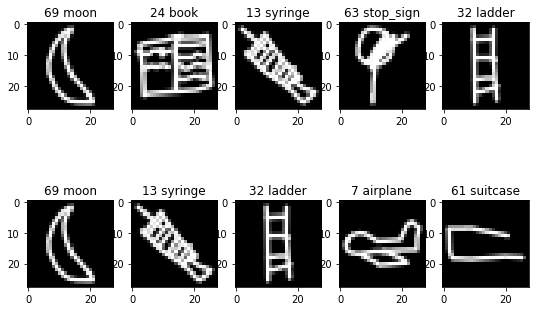

In [0]:
show_batch(x_test, y_test)

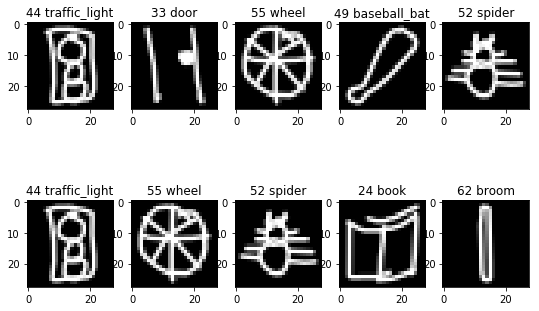

In [0]:
show_batch(x_test, y_test)

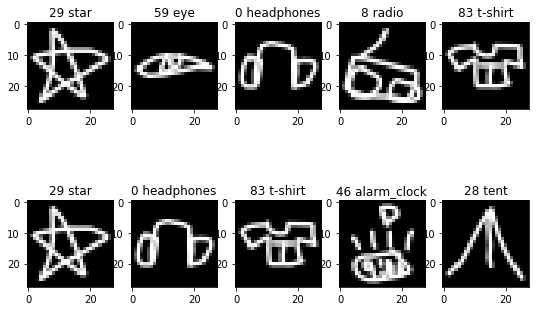

In [0]:
show_batch(x_test, y_test)

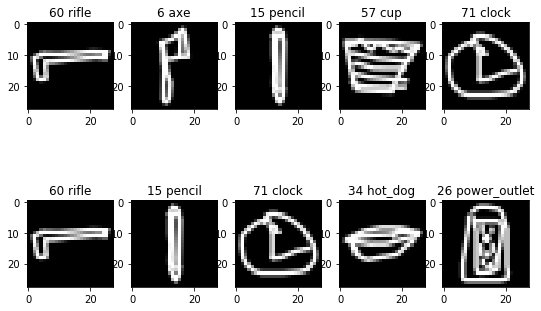

In [0]:
show_batch(x_test, y_test)

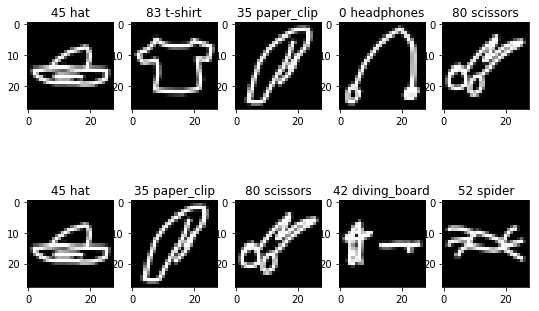

In [0]:
show_batch(x_test, y_test)

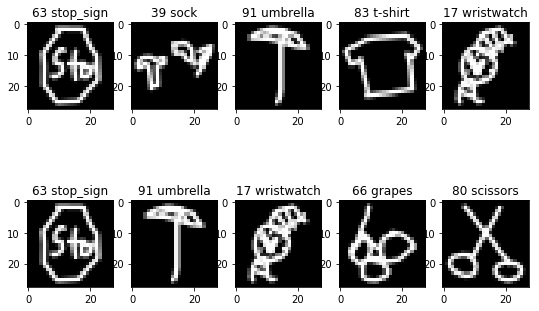

In [0]:
show_batch(x_test, y_test)